In [2]:
import azureml.core
import pandas as pd
import numpy as np
import logging

from azureml.core.workspace import Workspace
from azureml.core.experiment import Experiment
from azureml.train.automl import AutoMLConfig
from azureml.automl.core.featurization import FeaturizationConfig

# https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/automated-machine-learning/forecasting-orange-juice-sales/auto-ml-forecasting-orange-juice-sales.ipynb

In [3]:
print('You are currently using version', azureml.core.VERSION, 'of the Azure ML SDK')

You are currently using version 1.20.0 of the Azure ML SDK


In [4]:
# create an Experiment. An Experiment corresponds to a prediction problem you are trying to solve, while a Run corresponds to a specific approach to the problem.
ws = Workspace.from_config()

# choose a name for the run history container in the workspace
experiment_name = 'RevenueForecastRegion'

experiment = Experiment(ws, experiment_name)

output = {}
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['SKU'] = ws.sku
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Run History Name'] = experiment_name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data=output, index=[''])
outputDf.T

,
Subscription ID,db61fd47-db56-45e3-844f-1b1f5c47990a
Workspace,mlw-bi-automl-devqa01
SKU,Basic
Resource Group,rg-bi-automl-devqa01
Location,westus
Run History Name,RevenueForecastRegion


In [5]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your CPU cluster

amlcompute_cluster_name = 'cc-bi-ml-devqa01'

compute_target = ComputeTarget(workspace=ws,
                               name=amlcompute_cluster_name)
print ('Found existing cluster, use it.', compute_target)

Found existing cluster, use it. AmlCompute(workspace=Workspace.create(name='mlw-bi-automl-devqa01', subscription_id='db61fd47-db56-45e3-844f-1b1f5c47990a', resource_group='rg-bi-automl-devqa01'), name=cc-bi-ml-devqa01, id=/subscriptions/db61fd47-db56-45e3-844f-1b1f5c47990a/resourceGroups/rg-bi-automl-devqa01/providers/Microsoft.MachineLearningServices/workspaces/mlw-bi-automl-devqa01/computes/cc-bi-ml-devqa01, type=AmlCompute, provisioning_state=Succeeded, location=westus, tags=None)


In [6]:
%run ./helper.ipynb

In [7]:
'''
import os
import logging
import warnings
import datetime
from dateutil.tz import tzutc

from pandas.tseries.frequencies import to_offset
from pandas.io.json import json_normalize

# Squash warning messages for cleaner output in the notebook

warnings.showwarning = lambda *args, **kwargs: None

np.set_printoptions(precision=4, suppress=True, linewidth=120)
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from azureml.train.estimator import Estimator
'''

'\nimport os\nimport logging\nimport warnings\nimport datetime\nfrom dateutil.tz import tzutc\n\nfrom pandas.tseries.frequencies import to_offset\nfrom pandas.io.json import json_normalize\n\n# Squash warning messages for cleaner output in the notebook\n\nwarnings.showwarning = lambda *args, **kwargs: None\n\nnp.set_printoptions(precision=4, suppress=True, linewidth=120)\nfrom matplotlib import pyplot as plt\nfrom sklearn.metrics import mean_absolute_error, mean_squared_error\nfrom azureml.train.estimator import Estimator\n'

In [30]:
# read input files
import os


input_data_path = './revregion_inputs/'
output_data_path = './revregion_outputs/'
blobstore_datadir = 'revregionforecast_data'

if not os.path.isdir(input_data_path):
    os.mkdir(input_data_path, exist_ok=True)
if not os.path.isdir(output_data_path):
    os.mkdir(output_data_path, exist_ok=True)  

init_time_column_name = 'End of Month'
init_time_column_name1 = 'Snapshot Date Short'
init_time_column_name2 = 'Snapshot End of Month'
talenthist = pd.read_csv(input_data_path + 'TalentHistory.csv',
                         parse_dates=[init_time_column_name])
revhist = pd.read_csv(input_data_path + 'RevenueHistory.csv',
                      parse_dates=[init_time_column_name])
opphist = pd.read_csv(input_data_path + 'OppHistory.csv',
                      parse_dates=[init_time_column_name])
projhist = pd.read_csv(input_data_path + 'ProjectHistory.csv',
                       parse_dates=[init_time_column_name])
pipetrend = pd.read_csv(input_data_path + 'PipelineTrend.csv',
                        parse_dates=[init_time_column_name,
                       init_time_column_name1])
pipehist = pd.read_csv(input_data_path + 'PipelineHistory.csv',
                       parse_dates=[init_time_column_name,
                       init_time_column_name1])
display(talenthist.tail())
display(pipehist.tail())
display(revhist.tail())
display(opphist.tail())
display(projhist.tail())
display(pipetrend.tail())


,End of Month,Contrib Sub Region Code,Headcount,Headcount Contingent
536,2022-01-31,Academy,17.0000,nan
537,2022-01-31,Centers of Excellence,21.0000,nan
538,2022-01-31,Play Lab,20.0000,nan
539,2022-01-31,Global,20.2000,nan
540,2022-01-31,NaN,2.0000,1.0000


,Snapshot Date Short,Relative Snapshot Month Offset,End of Month,Relative Month Offset,Contrib Sub Region Code,Pipeline,Pipeline 3 Month Rolling Avg,Pipeline 3M Forward Avg,Pipeline 6M Forward Avg,Pipeline 6M Rolling Avg
13379,2021-02-15,0,2022-01-31,11,Europe,199476.83,360446.73,179321.5900,161378.4900,423437.6200
13380,2021-02-15,0,2022-01-31,11,Centers of Excellence,57193.95,94542.05,57193.9500,57193.9500,151039.2600
13381,2021-02-15,0,2022-01-31,11,Play Lab,NaN,NaN,nan,nan,31323.1600
13382,2021-02-15,0,2022-01-31,11,Global,NaN,21229.93,nan,nan,22043.2700
13383,2021-02-15,0,2022-01-31,11,NaN,82939.61,86889.11,84256.1100,66154.2100,86230.8600


,End of Month,Managing Sub Region Code,Revenue
397,2021-02-28,Academy,1035947.24
398,2021-02-28,Play Lab,272411.74
399,2021-02-28,Global,12130.10
400,2021-03-31,Academy,1005739.24
401,2021-03-31,Play Lab,50000.00


,End of Month,Managing Sub Region Code,Current Opp. Period Value
229,2021-01-31,Play Lab,1094000.0000
230,2021-01-31,NaN,0.0000
231,2021-02-28,North America,8895000.0000
232,2021-02-28,Europe,903328.6000
233,2021-02-28,Centers of Excellence,100000.0000


,End of Month,Managing Sub Region Code,Conversions
310,2021-02-28,Japan,96000.00
311,2021-02-28,North America,4238228.00
312,2021-02-28,Europe,724857.49
313,2021-02-28,Centers of Excellence,18000.00
314,2021-02-28,Play Lab,5000.00


,Snapshot Date Short,End of Month,Contrib Sub Region Code,Pipeline Trend,Pipeline Trend Avg
266,2021-02-15,2021-02-28,Academy,1486.5100,495.5000
267,2021-02-15,2021-02-28,Centers of Excellence,1895280.9900,631760.3300
268,2021-02-15,2021-02-28,Play Lab,723135.9100,241045.3000
269,2021-02-15,2021-02-28,Global,1160139.0000,386713.0000
270,2021-02-15,2021-02-28,NaN,414555.5700,138185.1900


 SP500: 


'SP500'

 DF Info: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 0 to 61
Data columns (total 2 columns):
End_of_Month    62 non-null datetime64[ns]
sp500           62 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.5 KB


None

 SP500 Describe: 


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
End_of_Month,62,62,2017-11-30,1,2016-01-31,2021-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sp500,62.000000,NaN,NaT,NaN,NaT,NaT,2729.373387,464.083593,1932.230000,2391.100000,2712.785000,2971.110000,3934.830000


 SP500 Head: 


,End_of_Month,sp500
0,2016-01-31,1940.240000
1,2016-02-29,1932.230000
2,2016-03-31,2059.740000
3,2016-04-30,2065.300000
4,2016-05-31,2096.960000


 SP500 Tail: 


,End_of_Month,sp500
57,2020-10-31,3269.960000
58,2020-11-30,3621.630000
59,2020-12-31,3756.070000
60,2021-01-31,3714.240000
61,2021-02-28,3934.830000


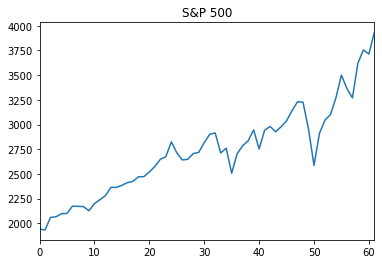

In [31]:
# download SP500 closing prices
# if you get an error after executing the code, try adding below.

!pip install pandas_datareader
import pandas_datareader.data as web
import pandas_datareader as pdr

import datetime

pd.set_option('display.float_format', lambda x: '%.6f' % x)

start = datetime.datetime(2016, 1, 1)
end = today

# pd.core.common.is_list_like = pd.api.types.is_list_like


# SP500 = web.DataReader(['sp500'], 'fred', start, end)
# display(SP500.head())

SP500 = pdr.get_data_fred('sp500', start, end)
SP500 = SP500.reset_index(level=SP500.index.names)
SP500['End_of_Month'] = SP500['DATE'] + pd.offsets.MonthEnd(0)
SP500 = SP500.sort_values('DATE').groupby('End_of_Month').last()

# SP500['Monthly_Return'] = (SP500['sp500']/ SP500['sp500'].shift(1)) -1
# SP500['sp500_1M_Previous'] = SP500['sp500'].shift(1)

SP500 = SP500.drop('DATE', axis=1)
SP500 = SP500.reset_index(level=SP500.index.names)

#Drop all Not a number values using drop method.
SP500.dropna(inplace = True)
print(' SP500: ')
display(get_df_name(SP500))
print(' DF Info: ')
display(SP500.info(verbose=True))
print(' SP500 Describe: ')
display(SP500.describe(include='all').transpose().head())
print(' SP500 Head: ')
display(SP500.head())
print(' SP500 Tail: ')
display(SP500.tail())
SP500['sp500'].plot(title='S&P 500')

In [86]:
# Data Preparation
# Rename Studio, filter studio and prep data

# set variales
target_column_name = 'Revenue'
time_column_name = 'Snapshot_Date_Short'
time_series_id_column_names = ['Relative_Offset','Sub_Region_Code']
sort_cols = ['Snapshot_Date_Short', 'End_of_Month', 'Sub_Region_Code']
sort_cols1 = ['End_of_Month', 'Sub_Region_Code']

exclude_sub_region = ['Singapore', 'NA']

pd.set_option('display.float_format', lambda x: '%.2f' % x)


# display(exclude_studio)

talenthist1 = talenthist.copy()
pipehist1 = pipehist.copy()
opphist1 = opphist.copy()
projhist1 = projhist.copy()
revhist1 = revhist.copy()
pipetrend1 = pipetrend.copy()
talenthist1.columns = \
    talenthist1.columns.astype(str).str.replace('Contrib ', '')
pipehist1.columns = pipehist1.columns.astype(str).str.replace('Contrib '
        , '')
pipetrend1.columns = \
    pipetrend1.columns.astype(str).str.replace('Contrib ', '')
opphist1.columns = opphist1.columns.astype(str).str.replace('Managing '
        , '')
projhist1.columns = \
    projhist1.columns.astype(str).str.replace('Managing ', '')
revhist1.columns = revhist1.columns.astype(str).str.replace('Managing '
        , '')


pipetrend1.drop(columns='Snapshot Date Short', axis=1, inplace = True)
# talenthist1 = talenthist.rename(columns={'Contrib Studio Name': 'Studio'})
# pipehist1 = pipehist.rename(columns={'Contrib Studio Name': 'Studio'})

# revhist1 = revhist.rename(columns={'Managing Studio Name': 'Studio'})

#pipetrend1 = \
#    pipetrend1.rename(columns={'Snapshot End of Month': 'End of Month'})

                                       # 'Contrib Studio Name': 'Studio'})
# opphist1 = opphist.rename(columns={'Managing Studio Name': 'Studio'})
# projhist1 = projhist.rename(columns={'Managing Studio Name': 'Studio'})
# revhist1 = revhist1.query('End_of_Month < @current_eom').reset_index(drop=True)

display(pipetrend1)
cols_float1 = opphist1.filter(like='Rate', axis=1).columns
remove_percetage(opphist1, cols_float1)
cols_float2 = pipehist1.filter(like='Yield', axis=1).columns
remove_percetage(pipehist1, cols_float2)

talenthist1 = data_prep(talenthist1)
pipehist1 = data_prep(pipehist1)
revhist1 = data_prep(revhist1)
pipetrend1 = data_prep(pipetrend1)
opphist1 = data_prep(opphist1)
projhist1 = data_prep(projhist1)
#display(pipetrend1)
coerce_df_columns_to_numeric(talenthist1)
coerce_df_columns_to_numeric(revhist1)
coerce_df_columns_to_numeric(opphist1)
coerce_df_columns_to_numeric(projhist1)
coerce_df_columns_to_numeric(pipehist1)
coerce_df_columns_to_numeric(pipetrend1)
# display(pipetrend1)
# show_stats(pipehist1)

#revhist1 = revhist1.query('Sub_Region_Code not in @exclude_sub_region').copy()

pipehist1['Snapshot_Date_Short'] = pipehist1['Snapshot_Date_Short'] \
    + pd.offsets.MonthEnd(0)  # make sure all End of Month are end of month dates
pipehist1['End_of_Month'] = pipehist1['End_of_Month'] \
    + pd.offsets.MonthEnd(0)  # make sure all End of Month are end of month dates
pipetrend1['End_of_Month'] = pipetrend1['End_of_Month'] \
    + pd.offsets.MonthEnd(0)  # make sure all End of Month are end of month dates
opphist1['End_of_Month'] = opphist1['End_of_Month'] \
    + pd.offsets.MonthEnd(0)
projhist1['End_of_Month'] = projhist1['End_of_Month'] \
    + pd.offsets.MonthEnd(0)
revhist1['End_of_Month'] = revhist1['End_of_Month'] \
    + pd.offsets.MonthEnd(0)
talenthist1['End_of_Month'] = talenthist1['End_of_Month'] \
    + pd.offsets.MonthEnd(0)

# Sort

pipehist1.sort_values(by=sort_cols).reset_index(drop=True)
revhist1.sort_values(by=sort_cols1).reset_index(drop=True)
talenthist1.sort_values(by=sort_cols1).reset_index(drop=True)
pipetrend1.sort_values(by=sort_cols1).reset_index(drop=True)
opphist1.sort_values(by=sort_cols1).reset_index(drop=True)
projhist1.sort_values(by=sort_cols1).reset_index(drop=True)

display(talenthist1.tail())
display(pipehist1.tail())
display(revhist1.tail())
display(opphist1.tail())
display(projhist.tail())
display(pipetrend1.tail())

,End of Month,Sub Region Code,Pipeline Trend,Pipeline Trend Avg
0,2018-07-31,China,961327.99,320442.66
1,2018-07-31,Japan,2009968.24,669989.41
2,2018-07-31,North America,38549549.12,12849849.71
3,2018-07-31,Europe,3452914.01,1150971.34
4,2018-07-31,Academy,52275.71,17425.24
...,...,...,...,...
266,2021-02-28,Academy,1486.51,495.50
267,2021-02-28,Centers of Excellence,1895280.99,631760.33
268,2021-02-28,Play Lab,723135.91,241045.30
269,2021-02-28,Global,1160139.00,386713.00


,End_of_Month,Sub_Region_Code,Headcount,Headcount_Contingent
535,2022-01-31,Europe,65,5
536,2022-01-31,Academy,17,0
537,2022-01-31,Centers of Excellence,21,0
538,2022-01-31,Play Lab,20,0
539,2022-01-31,Global,20,0


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Sub_Region_Code,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg
13378,2021-02-28,0,2022-01-31,11,North America,430636,1132669,415676,331779,1967861
13379,2021-02-28,0,2022-01-31,11,Europe,199476,360446,179321,161378,423437
13380,2021-02-28,0,2022-01-31,11,Centers of Excellence,57193,94542,57193,57193,151039
13381,2021-02-28,0,2022-01-31,11,Play Lab,0,0,0,0,31323
13382,2021-02-28,0,2022-01-31,11,Global,0,21229,0,0,22043


,End_of_Month,Sub_Region_Code,Revenue
397,2021-02-28,Academy,1035947
398,2021-02-28,Play Lab,272411
399,2021-02-28,Global,12130
400,2021-03-31,Academy,1005739
401,2021-03-31,Play Lab,50000


,End_of_Month,Sub_Region_Code,Current_Opp._Period_Value
228,2021-01-31,Europe,6590215
229,2021-01-31,Play Lab,1094000
231,2021-02-28,North America,8895000
232,2021-02-28,Europe,903328
233,2021-02-28,Centers of Excellence,100000


,End of Month,Managing Sub Region Code,Conversions
310,2021-02-28,Japan,96000.00
311,2021-02-28,North America,4238228.00
312,2021-02-28,Europe,724857.49
313,2021-02-28,Centers of Excellence,18000.00
314,2021-02-28,Play Lab,5000.00


,End_of_Month,Sub_Region_Code,Pipeline_Trend,Pipeline_Trend_Avg
265,2021-02-28,Europe,5215971,1738657
266,2021-02-28,Academy,1486,495
267,2021-02-28,Centers of Excellence,1895280,631760
268,2021-02-28,Play Lab,723135,241045
269,2021-02-28,Global,1160139,386713


In [87]:
display(pipehist1.query('Relative_Snapshot_Month_Offset == 0'))

,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Sub_Region_Code,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg
12876,2021-02-28,0,2017-01-31,-49,China,639967,3257877,684915,744826,3257877
12877,2021-02-28,0,2017-01-31,-49,Japan,329393,2161373,353251,368499,2161373
12879,2021-02-28,0,2017-01-31,-49,North America,9428261,58284461,9705325,9699050,58284461
12880,2021-02-28,0,2017-01-31,-49,Europe,1155943,8450199,1225365,1226738,8450199
12881,2021-02-28,0,2017-01-31,-49,Academy,589253,1924815,495201,482252,1924815
...,...,...,...,...,...,...,...,...,...,...
13378,2021-02-28,0,2022-01-31,11,North America,430636,1132669,415676,331779,1967861
13379,2021-02-28,0,2022-01-31,11,Europe,199476,360446,179321,161378,423437
13380,2021-02-28,0,2022-01-31,11,Centers of Excellence,57193,94542,57193,57193,151039
13381,2021-02-28,0,2022-01-31,11,Play Lab,0,0,0,0,31323


In [88]:
print(' revhist1: ')

# revhist1.to_csv('revhist1.csv', index=False)
# show_stats(revhist1)
# display(revhist1.query('Fin_Entity_ID==@entity_debug').reset_index(drop=True))
# pivot

revhist_pivot = revhist1.pivot_table(index=['End_of_Month','Sub_Region_Code'],
        values='Revenue', margins=False)  # columns = ['Fin_Entity_ID'],
                                          # aggfunc=['sum','count'],

# revhist_pivot = revhist_pivot.rename(columns={'sum':'Revenue'})

revhist_pivot = \
    revhist_pivot.reset_index()

# revhist_pivot['End_of_Month'] = pd.to_datetime(revhist_pivot['End_of_Month'])#.dt.date
# revhist_pivot.index.name = 'Date'

revhist_pivot.fillna(0, inplace=True)
revhist_pivot.tail(10)


 revhist1: 


,End_of_Month,Sub_Region_Code,Revenue
388,2021-01-31,Global,0
389,2021-01-31,Japan,758445
390,2021-01-31,North America,7568497
391,2021-01-31,Play Lab,1727209
392,2021-02-28,Academy,1035947
393,2021-02-28,Europe,411
394,2021-02-28,Global,12130
395,2021-02-28,Play Lab,272411
396,2021-03-31,Academy,1005739
397,2021-03-31,Play Lab,50000


In [89]:
# Cross join to get all unquie values of End_of_Month and Sub_Region_Code

d = pd.date_range(start_date, end_date, freq='m')
eom = pd.DataFrame(d, columns=['End_of_Month'])

# eom = pipehist_pivot1[['End_of_Month']].drop_duplicates(subset='End_of_Month',keep='last').sort_values(by=['End_of_Month']).reset_index(drop=True)
sub_region_code = pd.DataFrame(talenthist1['Sub_Region_Code'].unique(), columns=['Sub_Region_Code'])
eom['key'] = 0
sub_region_code['key'] = 0
eom_region = pd.merge(eom, sub_region_code, on=['key'])
eom_region = eom_region.replace(np.nan, 'Unknown', regex=True)
eom_region.drop(columns=['key'], axis=1, inplace = True)

print(' eom_region: ')

display(eom_region.info(verbose=True))
eom_region

 eom_region: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 488 entries, 0 to 487
Data columns (total 2 columns):
End_of_Month       488 non-null datetime64[ns]
Sub_Region_Code    488 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 11.4+ KB


None

,End_of_Month,Sub_Region_Code
0,2017-01-31,China
1,2017-01-31,Japan
2,2017-01-31,North America
3,2017-01-31,Europe
4,2017-01-31,Academy
...,...,...
483,2022-01-31,Europe
484,2022-01-31,Academy
485,2022-01-31,Centers of Excellence
486,2022-01-31,Play Lab


In [90]:
# Merge eom_studio with Revenue, Talent, Opportunity, Project

from functools import reduce
nan_value = 0
merge_dfs = [
    eom_region,
    revhist1,
    talenthist1,
    opphist1,
    projhist1,
    pipetrend1,
    ]

merge_df = reduce(lambda left, right: pd.merge(left, right, how='left',
                  on=['End_of_Month','Sub_Region_Code']), merge_dfs).fillna(nan_value)
coerce_df_columns_to_numeric(merge_df)
merge_df = merge_df.replace(np.nan, 0, regex=True)

# merge_df = merge_df.query('Fin_Entity_ID!='SGP'') # Exclude Singapore rows

merge_df['Relative_Month_Offset'] = round((merge_df['End_of_Month']
        - current_eom) / np.timedelta64(1, 'M'), 0).astype(int)
merge_df['Billable_Headcount'] = merge_df['Headcount'] \
    + merge_df['Headcount_Contingent']
merge_df.sort_values(by=sort_cols1).reset_index(drop=True)

# merge_df.drop(columns=['Current_Opp._Period_Value','Conversions'], axis=1, inplace = True)

print(' merge_df: ',merge_df.shape)

# merge_df.to_csv(output_data_path + 'merge_df.csv', index=False)
# show_stats(merge_df)

merge_df  # .query('Fin_Entity_ID==@entity_debug')')

 merge_df:  (488, 11)


,End_of_Month,Sub_Region_Code,Revenue,Headcount,Headcount_Contingent,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Relative_Month_Offset,Billable_Headcount
0,2017-01-31,China,639967,26,0,0,434540,0,0,-49,26
1,2017-01-31,Japan,329393,18,0,0,0,0,0,-49,18
2,2017-01-31,North America,9428262,342,19,0,11981645,0,0,-49,361
3,2017-01-31,Europe,1155943,50,4,0,922408,0,0,-49,54
4,2017-01-31,Academy,589253,14,0,0,69626,0,0,-49,14
...,...,...,...,...,...,...,...,...,...,...,...
483,2022-01-31,Europe,0,65,5,0,0,0,0,11,70
484,2022-01-31,Academy,0,17,0,0,0,0,0,11,17
485,2022-01-31,Centers of Excellence,0,21,0,0,0,0,0,11,21
486,2022-01-31,Play Lab,0,20,0,0,0,0,0,11,20


In [91]:
# Merge with SP500

eom_region1 = eom_region.copy()  # pd.DataFrame(d, columns=['End_of_Month'])
sp500_df = pd.merge(eom_region1, SP500, how='left', on=['End_of_Month'])

# sp500_df = sp500_df.ffill(axis = 0)

sp500_df = sp500_df.sort_values(by=sort_cols1).reset_index(drop=True)
display(sp500_df)
merge_df1 = pd.merge(merge_df, sp500_df, how='left', on=['End_of_Month','Sub_Region_Code'])
coerce_df_columns_to_numeric(merge_df1)
display(merge_df1)
merge_df1.drop(columns=['Headcount', 'Headcount_Contingent'], axis=1,
               inplace=True) 
merge_df1['End_of_Month'] = \
    pd.to_datetime(merge_df1['End_of_Month'])
merge_df1 = merge_df1.sort_values(by=sort_cols1).reset_index(drop=True)
# merge_df1.to_csv(output_data_path + 'merge_df1.csv', index=False)
show_stats(merge_df1)

,End_of_Month,Sub_Region_Code,sp500
0,2017-01-31,Academy,2278.87
1,2017-01-31,Centers of Excellence,2278.87
2,2017-01-31,China,2278.87
3,2017-01-31,Europe,2278.87
4,2017-01-31,Global,2278.87
...,...,...,...
483,2022-01-31,Europe,nan
484,2022-01-31,Global,nan
485,2022-01-31,Japan,nan
486,2022-01-31,North America,nan


,End_of_Month,Sub_Region_Code,Revenue,Headcount,Headcount_Contingent,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Relative_Month_Offset,Billable_Headcount,sp500
0,2017-01-31,China,639967,26,0,0,434540,0,0,-49,26,2278.87
1,2017-01-31,Japan,329393,18,0,0,0,0,0,-49,18,2278.87
2,2017-01-31,North America,9428262,342,19,0,11981645,0,0,-49,361,2278.87
3,2017-01-31,Europe,1155943,50,4,0,922408,0,0,-49,54,2278.87
4,2017-01-31,Academy,589253,14,0,0,69626,0,0,-49,14,2278.87
...,...,...,...,...,...,...,...,...,...,...,...,...
483,2022-01-31,Europe,0,65,5,0,0,0,0,11,70,nan
484,2022-01-31,Academy,0,17,0,0,0,0,0,11,17,nan
485,2022-01-31,Centers of Excellence,0,21,0,0,0,0,0,11,21,nan
486,2022-01-31,Play Lab,0,20,0,0,0,0,0,11,20,nan


 DF Name: 


'merge_df1'

 DF Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 488 entries, 0 to 487
Data columns (total 10 columns):
End_of_Month                 488 non-null datetime64[ns]
Sub_Region_Code              488 non-null object
Revenue                      488 non-null int64
Current_Opp._Period_Value    488 non-null int64
Conversions                  488 non-null int64
Pipeline_Trend               488 non-null int64
Pipeline_Trend_Avg           488 non-null int64
Relative_Month_Offset        488 non-null int64
Billable_Headcount           488 non-null int64
sp500                        400 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(7), object(1)
memory usage: 38.2+ KB


None

 DF Describe: 


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
End_of_Month,488,61,2017-11-30 00:00:00,8,2017-01-31,2022-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sub_Region_Code,488,8,Play Lab,61,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Revenue,488.00,NaN,NaN,NaN,NaT,NaT,1452109.26,2877483.60,0.00,100238.25,471527.50,959904.00,12137512.00
Current_Opp._Period_Value,488.00,NaN,NaN,NaN,NaT,NaT,2591037.57,7592464.26,0.00,0.00,0.00,1229675.00,80901726.00
Conversions,488.00,NaN,NaN,NaN,NaT,NaT,1267172.16,2942068.52,0.00,0.00,60719.00,762485.25,18709504.00


 DF Head: 


,End_of_Month,Sub_Region_Code,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Relative_Month_Offset,Billable_Headcount,sp500
0,2017-01-31,Academy,589253,0,69626,0,0,-49,14,2278.87
1,2017-01-31,Centers of Excellence,317276,0,50000,0,0,-49,9,2278.87
2,2017-01-31,China,639967,0,434540,0,0,-49,26,2278.87
3,2017-01-31,Europe,1155943,0,922408,0,0,-49,54,2278.87
4,2017-01-31,Global,54366,0,47470,0,0,-49,16,2278.87


 DF Tail: 


,End_of_Month,Sub_Region_Code,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Relative_Month_Offset,Billable_Headcount,sp500
483,2022-01-31,Europe,0,0,0,0,0,11,70,nan
484,2022-01-31,Global,0,0,0,0,0,11,20,nan
485,2022-01-31,Japan,0,0,0,0,0,11,35,nan
486,2022-01-31,North America,0,0,0,0,0,11,286,nan
487,2022-01-31,Play Lab,0,0,0,0,0,11,20,nan


 EOM Sum:


,End_of_Month,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Relative_Month_Offset,Billable_Headcount,sp500
0,2017-01-31,12796336,0,13505689,0,0,-392,509,18230.96
1,2017-02-28,12476754,0,8659142,0,0,-384,509,18909.12
2,2017-03-31,14191126,0,12745281,0,0,-376,510,18901.76
3,2017-04-30,12449450,0,10701239,0,0,-368,504,19073.60
4,2017-05-31,13669409,0,6457961,0,0,-360,510,19294.40


 EOM Count: 


,End_of_Month,Sub_Region_Code,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Relative_Month_Offset,Billable_Headcount,sp500
0,2017-01-31,8,8,8,8,8,8,8,8,8
1,2017-02-28,8,8,8,8,8,8,8,8,8
2,2017-03-31,8,8,8,8,8,8,8,8,8
3,2017-04-30,8,8,8,8,8,8,8,8,8
4,2017-05-31,8,8,8,8,8,8,8,8,8


In [92]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# Calculate pipeline month offset for corresponding snapshot dates

n_test_periods = 4
rolling_pipeline_period = 4
relative_offset_periods = 11
pipehist_long = pipehist1.copy()

pipehist_long['Relative_Offset'] = pipehist_long['Relative_Month_Offset'
        ] - pipehist_long['Relative_Snapshot_Month_Offset']
pipehist_long = \
    pipehist_long.query('Relative_Offset >= -@relative_offset_periods and \
                        Relative_Offset < @rolling_pipeline_period and \
                        Snapshot_Date_Short < @end_date'
                        )
cols = 'Relative_Offset'
pipehist_long[cols] = pipehist_long[cols].apply(pd.to_numeric,
        errors='coerce')
pipehist_long['Snapshot_Date_Short'] = \
    pd.to_datetime(pipehist_long['Snapshot_Date_Short'])
pipehist_long['End_of_Month'] = \
    pd.to_datetime(pipehist_long['End_of_Month'])


# pipehist2 = pipehist2.query('Relative_Offset>=-11 and Relative_Offset<=0')
# pipehist_long['Relative_Offset'] = pipehist_long['Relative_Offset'].astype(str).str.zfill(2) + 'M Pipeline'
# pipehist_long['Relative_Offset'] = pipehist_long['Relative_Offset'].str.replace('0','+')
# pipehist_long['Relative_Offset'] = pipehist_long['Relative_Offset'].str.replace('++M Pipeline','+0M Pipeline')
# pipehist_long['Relative_Offset'] = 'Relative' + pipehist_long['Relative_Offset'].str.replace('0-','-0')

pipehist_long.sort_values(by=sort_cols).reset_index(drop=True)  # ,'Fin_Entity_ID'

print (' pipehist_long: ')

# pipehist_long.to_csv(output_data_path + 'pipehist_long.csv',
#                     index=False)
display(pipehist_long)  # .query('Fin_Entity_ID==@entity_debug'))
pipehist_long.info()

 pipehist_long: 


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Sub_Region_Code,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Relative_Offset
63,2018-07-31,-31,2017-08-31,-42,China,730547,701119,612395,625170,752322,-11
64,2018-07-31,-31,2017-08-31,-42,Japan,442962,408862,464365,471270,396981,-11
66,2018-07-31,-31,2017-08-31,-42,North America,10096961,9509710,9681468,9665164,9734598,-11
67,2018-07-31,-31,2017-08-31,-42,Europe,1150868,1232152,1327478,1267044,1251953,-11
68,2018-07-31,-31,2017-08-31,-42,Academy,447221,478366,665024,650370,484260,-11
...,...,...,...,...,...,...,...,...,...,...,...
13311,2021-02-28,0,2021-05-31,3,Europe,1526941,1668875,1103380,794904,1747609,3
13312,2021-02-28,0,2021-05-31,3,Academy,0,1005739,0,0,745639,3
13313,2021-02-28,0,2021-05-31,3,Centers of Excellence,459073,611560,436646,322091,499730,3
13314,2021-02-28,0,2021-05-31,3,Play Lab,105564,218797,87689,65142,579876,3


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3840 entries, 63 to 13315
Data columns (total 11 columns):
Snapshot_Date_Short               3840 non-null datetime64[ns]
Relative_Snapshot_Month_Offset    3840 non-null int64
End_of_Month                      3840 non-null datetime64[ns]
Relative_Month_Offset             3840 non-null int64
Sub_Region_Code                   3840 non-null object
Pipeline                          3840 non-null int64
Pipeline_3_Month_Rolling_Avg      3840 non-null int64
Pipeline_3M_Forward_Avg           3840 non-null int64
Pipeline_6M_Forward_Avg           3840 non-null int64
Pipeline_6M_Rolling_Avg           3840 non-null int64
Relative_Offset                   3840 non-null int64
dtypes: datetime64[ns](2), int64(8), object(1)
memory usage: 360.0+ KB


In [93]:
# Convert pipe history from long to wide to match month end grain

pipehist_wide = pipehist_long.pivot_table(index='Snapshot_Date_Short', columns='Relative_Offset',
        values=['Pipeline', 'Pipeline_3_Month_Rolling_Avg'],
        aggfunc={'Pipeline':np.sum , 'Pipeline_3_Month_Rolling_Avg':np.mean}, margins=False)  # ,'Fin_Entity_ID'
pipehist_wide = \
    pipehist_wide.reset_index(level=pipehist_wide.index.names).reset_index(drop=True)
cols = list(pipehist_wide.select_dtypes(include='float64').columns)
coerce_df_columns_to_numeric(pipehist_wide)
pipehist_wide['Snapshot_Date_Short'] = \
    pd.to_datetime(pipehist_wide['Snapshot_Date_Short'])

# pipehist_wide.rename(columns={0:'Pipeline_3_Month_Rolling_Avg'}, inplace=True)

pipehist_wide = pipehist_wide.sort_values(by='Snapshot_Date_Short').reset_index(drop=True)

print(' pipehist_wide: ')

display(pipehist_wide.info())

# pipehist_wide.query('Fin_Entity_ID==@entity_debug')

pipehist_wide

 pipehist_wide: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 31 columns):
(Snapshot_Date_Short, )                32 non-null datetime64[ns]
(Pipeline, -11)                        32 non-null int64
(Pipeline, -10)                        32 non-null int64
(Pipeline, -9)                         32 non-null int64
(Pipeline, -8)                         32 non-null int64
(Pipeline, -7)                         32 non-null int64
(Pipeline, -6)                         32 non-null int64
(Pipeline, -5)                         32 non-null int64
(Pipeline, -4)                         32 non-null int64
(Pipeline, -3)                         32 non-null int64
(Pipeline, -2)                         32 non-null int64
(Pipeline, -1)                         32 non-null int64
(Pipeline, 0)                          32 non-null int64
(Pipeline, 1)                          32 non-null int64
(Pipeline, 2)                          32 non-null int64
(Pipeline, 3)   

None

Snapshot_Date_Short  Pipeline                                                                                                                                             Pipeline_3_Month_Rolling_Avg                                                                                                                              
Relative_Offset                           -11       -10        -9        -8        -7        -6        -5        -4        -3        -2        -1         0         1         2         3                          -11      -10       -9       -8       -7       -6       -5       -4       -3       -2       -1        0        1        2        3
0               2018-07-31           13644811  13257048  13700128  13429236  12003450  14688390  13055988  15149544  14597786  16502901  14816104  13046086  19060365  16240817  16378064  1616550                      1613092  1691749  1682767  1622642  1664862  1652996  1784083  1775746  1910890  1900419  1839472  1955106  2014469  2156107
1               2018-08-31           13257048  13700128  13429236  12003450  14688390  13055988  15149544  14597786  16502901  14816104  14385067  14014610  16891816  21721973  15793982  1613092                      1691749  1682767  1622642  1664862  1652996  1784083  1775746  1910890  1900419  1891556  1800657  1887145  2192850  2268512
2               2018-09-30           13700132  13429234  12003452  14688390  13055988  15149544  14597785  16502901  14816104  14385072  15827437  13525104  29841976  26499629  15495233  1691749                      1682767  1622643  1664861  1652996  1784083  1775746  1910890  1900419  1891556  1876192  1822400  2466438  2911113  3003042
3               2018-10-31           13429234  12003452  14688390  13055988  15149544  14597785  16502901  14816104  14385071  15827436  14759297  16301928  15885517  13170988  10173070  1682767                      1622643  1664861  1652996  1784083  1775746  1910890  1900419  1891556  1876192  1873825  1986898  1971656  1893152  1634565
4               2018-11-30           12003452  14688390  13055988  15149544  14597785  16502901  14816104  14385071  15827436  14759297  17699519  13677007  14060560  16270533  12916687  1622643                      1664861  1652996  1784083  1775746  1910890  1900419  1891556  1876192  1873825  2001260  1948010  1909789  1835807  1804127
5               2018-12-31           14688390  13055988  15149544  14597785  16502901  14816104  14384068  15827437  14759377  17699515  14995702  11534332  16802665  16818867  14970178  1664861                      1652996  1784083  1775746  1910890  1900419  1891514  1876150  1873786  2001263  1955604  1821967  1803982  1879947  2024654
6               2019-01-31           13055988  15149544  14597785  16502901  14816104  14384068  15827437  14759377  17699515  14995702  13193819  13445088  15577786  17810584  15681087  1652996                      1784083  1775746  1910890  1900419  1891514  1876150  1873786  2001263  1955604  1894655  1764437  1774431  1953451  2046829
7               2019-02-28           15149544  14597786  16502901  14816104  14384068  15827437  14759377  17699515  14995702  13193819  15784852  13596470  20275832  19934855  13562271  1784083                      1775746  1910890  1900419  1891514  1876150  1873786  2001263  1955604  1894655  1832265  1773964  2069047  2241965  2240540
8               2019-03-31           14597786  16502901  14816104  14384068  15827437  14759377  17699515  14995702  13193819  15644435  14976394  16087190  17363701  15824533  11591164  1775746                      1910890  1900419  1891514  1876150  1873786  2001263  1955604  1894655  1826414  1825299  1945856  2017493  2053142  1865808
9               2019-04-30           16502901  14816104  14384068  15827437  14759377  17699515  14995702  13193819  15644435  14982607  16782109  15500215  16723398  15378212  13076812  1910890                      1900419  1891514  1876150  1873786  2001263  1955

In [94]:
'''
# Merge merge_df with Pipeline Long History
# pipe_offset = ['Relative-00','Relative-01','Relative-02','Relative-03',
#               'Relative-04','Relative-05','Relative-06'
#               ,'Relative-07', 'Relative-08','Relative-09','Relative-10','Relative-11'
#              ]
# 1merge_final = pd.merge(merge_df1, pipehist_long.query('Relative_Offset == 0'), how='left', on=['End_of_Month','Relative_Month_Offset','Fin_Entity_ID'])
# 1merge_final.drop(columns=['Snapshot_Date_Short','Relative_Snapshot_Month_Offset'], axis=1, inplace = True)
# New Code
'''

pipehist_long1 = pipehist_long.copy() 
display(pipehist_long1.head())
display(merge_df1.head())

merge_final = pd.merge(pipehist_long1, merge_df1, how='right',
                       on=['End_of_Month', 'Relative_Month_Offset','Sub_Region_Code'])
merge_final = merge_final.query('Relative_Snapshot_Month_Offset <= 0')
# merge_final.drop(columns=['Snapshot_Date_Short','Relative_Snapshot_Month_Offset'], axis=1, inplace = True)
# New Code end
merge_final = merge_final.sort_values(by=sort_cols).reset_index(drop=True)

merge_final['End_of_Month'] = pd.to_datetime(merge_final['End_of_Month'
        ])
merge_final['Relative_Month_Offset'] = round((merge_final['End_of_Month'
        ] - current_eom) / np.timedelta64(1, 'M'), 0)
coerce_df_columns_to_numeric(merge_final)

merge_final['Relative_Offset'] = merge_final['Relative_Offset'
        ].apply(pd.to_numeric, errors='coerce').replace(np.nan, 0,
        regex=True).astype(int)
cond = ~merge_final['Snapshot_Date_Short'].isna()
merge_final['Snapshot_Date_Short'] = np.where(cond,
        merge_final['Snapshot_Date_Short'], merge_final['End_of_Month'])
merge_final['Relative_Snapshot_Month_Offset'] = \
    round((merge_final['Snapshot_Date_Short'] - current_eom)
          / np.timedelta64(1, 'M'), 0).astype(int)

# Filter for only next 11 months rows w.r.t. to snapshot date
# revpipe_final1 = revpipe_final.query('Relative_Offset in @pipe_offset').reset_index(drop=True)
merge_final = merge_final.replace(np.nan, 0, regex=True)
coerce_df_columns_to_numeric(merge_final)
merge_final = merge_final.sort_values(by=sort_cols).reset_index(drop=True)
display(merge_final.info())
merge_final.rename(columns={
    -12: '-12M Pipeline',
    -11: '-11M Pipeline',
    -10: '-10M Pipeline',
    -9: '-9M Pipeline',
    -8: '-8M Pipeline',
    -7: '-7M Pipeline',
    -6: '-6M Pipeline',
    -5: '-5M Pipeline',
    -4: '-4M Pipeline',
    -3: '-3M Pipeline',
    -2: '-2M Pipeline',
    -1: '-1M Pipeline',
    0: '0M Pipeline',
    1: '1M Pipeline',
    2: '2M Pipeline',
    3: '3M Pipeline',
    4: '4M Pipeline',
    5: '5M Pipeline',
    6: '6M Pipeline',
    7: '7M Pipeline',
    8: '8M Pipeline',
    9: '9M Pipeline',
    10: '10M Pipeline',
    11: '11M Pipeline',
    }, inplace=True)

print(' merge_final: ')

merge_final.to_csv(output_data_path + 'merge_final.csv', index=False)
merge_final.to_parquet(output_data_path + 'merge_final.parquet',
                       index=None)
show_stats(merge_final)

,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Sub_Region_Code,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Relative_Offset
63,2018-07-31,-31,2017-08-31,-42,China,730547,701119,612395,625170,752322,-11
64,2018-07-31,-31,2017-08-31,-42,Japan,442962,408862,464365,471270,396981,-11
66,2018-07-31,-31,2017-08-31,-42,North America,10096961,9509710,9681468,9665164,9734598,-11
67,2018-07-31,-31,2017-08-31,-42,Europe,1150868,1232152,1327478,1267044,1251953,-11
68,2018-07-31,-31,2017-08-31,-42,Academy,447221,478366,665024,650370,484260,-11


,End_of_Month,Sub_Region_Code,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Relative_Month_Offset,Billable_Headcount,sp500
0,2017-01-31,Academy,589253,0,69626,0,0,-49,14,2278.87
1,2017-01-31,Centers of Excellence,317276,0,50000,0,0,-49,9,2278.87
2,2017-01-31,China,639967,0,434540,0,0,-49,26,2278.87
3,2017-01-31,Europe,1155943,0,922408,0,0,-49,54,2278.87
4,2017-01-31,Global,54366,0,47470,0,0,-49,16,2278.87


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840 entries, 0 to 3839
Data columns (total 18 columns):
Snapshot_Date_Short               3840 non-null datetime64[ns]
Relative_Snapshot_Month_Offset    3840 non-null int64
End_of_Month                      3840 non-null datetime64[ns]
Relative_Month_Offset             3840 non-null int64
Sub_Region_Code                   3840 non-null object
Pipeline                          3840 non-null int64
Pipeline_3_Month_Rolling_Avg      3840 non-null int64
Pipeline_3M_Forward_Avg           3840 non-null int64
Pipeline_6M_Forward_Avg           3840 non-null int64
Pipeline_6M_Rolling_Avg           3840 non-null int64
Relative_Offset                   3840 non-null int64
Revenue                           3840 non-null int64
Current_Opp._Period_Value         3840 non-null int64
Conversions                       3840 non-null int64
Pipeline_Trend                    3840 non-null int64
Pipeline_Trend_Avg                3840 non-null int64
Billable_H

None

 merge_final: 
 DF Name: 


'merge_final'

 DF Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840 entries, 0 to 3839
Data columns (total 18 columns):
Snapshot_Date_Short               3840 non-null datetime64[ns]
Relative_Snapshot_Month_Offset    3840 non-null int64
End_of_Month                      3840 non-null datetime64[ns]
Relative_Month_Offset             3840 non-null int64
Sub_Region_Code                   3840 non-null object
Pipeline                          3840 non-null int64
Pipeline_3_Month_Rolling_Avg      3840 non-null int64
Pipeline_3M_Forward_Avg           3840 non-null int64
Pipeline_6M_Forward_Avg           3840 non-null int64
Pipeline_6M_Rolling_Avg           3840 non-null int64
Relative_Offset                   3840 non-null int64
Revenue                           3840 non-null int64
Current_Opp._Period_Value         3840 non-null int64
Conversions                       3840 non-null int64
Pipeline_Trend                    3840 non-null int64
Pipeline_Trend_Avg                3840 non-null int64

None

 DF Describe: 


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Snapshot_Date_Short,3840,32,2019-02-28 00:00:00,120,2018-07-31,2021-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Snapshot_Month_Offset,3840.00,NaN,NaN,NaN,NaT,NaT,-15.50,9.23,-31.00,-23.25,-15.50,-7.75,0.00
End_of_Month,3840,46,2020-01-31 00:00:00,120,2017-08-31,2021-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Month_Offset,3840.00,NaN,NaN,NaN,NaT,NaT,-19.50,10.20,-42.00,-27.25,-19.50,-11.75,3.00
Sub_Region_Code,3840,8,Japan,480,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 DF Head: 


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Sub_Region_Code,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Relative_Offset,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,sp500
0,2018-07-31,-31,2017-08-31,-42,Academy,447221,478366,665024,650370,484260,-11,447221,0,0,0,0,19,2471.65
1,2018-07-31,-31,2017-08-31,-42,Centers of Excellence,265949,263570,248755,263910,219088,-11,265949,0,0,0,0,12,2471.65
2,2018-07-31,-31,2017-08-31,-42,China,730547,701119,612395,625170,752322,-11,730547,0,0,0,0,25,2471.65
3,2018-07-31,-31,2017-08-31,-42,Europe,1150868,1232152,1327478,1267044,1251953,-11,1150868,0,2005673,0,0,53,2471.65
4,2018-07-31,-31,2017-08-31,-42,Global,215733,102216,142049,66858,136035,-11,215733,0,1000,0,0,14,2471.65


 DF Tail: 


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Sub_Region_Code,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Relative_Offset,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,sp500
3835,2021-02-28,0,2021-05-31,3,Europe,1526941,1668875,1103380,794904,1747609,3,0,0,0,0,0,70,0.00
3836,2021-02-28,0,2021-05-31,3,Global,395334,439330,268675,145630,304131,3,0,0,0,0,0,22,0.00
3837,2021-02-28,0,2021-05-31,3,Japan,821812,910175,448990,303480,881968,3,0,0,0,0,0,35,0.00
3838,2021-02-28,0,2021-05-31,3,North America,4864571,8071729,4513339,3658196,8097607,3,0,0,0,0,0,301,0.00
3839,2021-02-28,0,2021-05-31,3,Play Lab,105564,218797,87689,65142,579876,3,0,0,0,0,0,20,0.00


 EOM Sum:


,End_of_Month,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Relative_Offset,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,sp500
0,2017-08-31,-248,-336,13644811,12932407,13533996,13422278,13184535,-88,13644811,0,6762094,0,0,518,19773.20
1,2017-09-30,-488,-656,26514096,25809482,26924274,26613866,26057710,-168,26514096,0,9060342,0,0,1036,40309.76
2,2017-10-31,-720,-960,41100388,40601988,38943430,40825972,39711901,-240,41100384,0,20346957,0,0,1605,61806.24
3,2017-11-30,-944,-1248,53716940,53848552,53242256,55033064,52789096,-304,53716944,0,29632992,0,0,2172,84722.56
4,2017-12-31,-1160,-1520,60017256,64905718,65758650,71097123,64714710,-360,60017250,0,20854085,0,0,2635,106944.40


 EOM Count: 


,End_of_Month,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Sub_Region_Code,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Relative_Offset,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,sp500
0,2017-08-31,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
1,2017-09-30,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16
2,2017-10-31,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24
3,2017-11-30,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32
4,2017-12-31,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40


 SDS Sum:


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Relative_Offset,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,sp500
0,2018-07-31,-3720,-4200,219570718,215047658,213903845,198822982,210175607,-480,217515782,241606552,156913474,220221299,73407090,8300,323849.52
1,2018-08-31,-3600,-4080,224008023,218719783,215919808,199822900,212768635,-480,218866674,287628199,163336533,260698886,86899617,8385,326157.68
2,2018-09-30,-3480,-3960,243517981,237255209,236841078,222768516,223007167,-480,218803444,327713457,169755194,307316430,102438795,8458,326057.60
3,2018-10-31,-3360,-3840,214746705,216978037,204924268,187720128,214602161,-480,220747750,372454619,187839741,356781588,118927179,8525,327088.32
4,2018-11-30,-3240,-3720,220410274,219617675,215136476,200840078,217107375,-480,222301111,393372253,194250468,408442454,136147465,8588,328183.60


 SDS Count: 


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Sub_Region_Code,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Relative_Offset,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,sp500
0,2018-07-31,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120
1,2018-08-31,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120
2,2018-09-30,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120
3,2018-10-31,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120
4,2018-11-30,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120


In [95]:
# To distinguish the individual time-series, we define the time_series_id_column_names - the columns whose values determine the boundaries between time-series:
sort_list = [time_column_name] + list(set(time_series_id_column_names))
df = merge_final.copy()

In [96]:
# Data Split
# split the data into a training and a testing set for later forecast evaluation. The test set will contain the final test_size months of observed sales for each time-series.
# The splits should be stratified by series, so we use a group-by statement on the time series identifier columns.
# test_size = .11 #in percentage
# n_test_periods =  int(tseries * test_size)
# n_test_periods = rolling_pipeline_period

In [97]:
tseries = df.groupby(time_column_name).ngroups
display('Data contains {0} individual time_column_name.'.format(tseries))
test_size = round(n_test_periods / tseries, 2)
display('Test Size: ', test_size, 'Test Periods: ', n_test_periods)
display(df[time_column_name].unique())

'Data contains 32 individual time_column_name.'

'Test Size: '

0.12

'Test Periods: '

4

array(['2018-07-31T00:00:00.000000000', '2018-08-31T00:00:00.000000000',
       '2018-09-30T00:00:00.000000000', '2018-10-31T00:00:00.000000000',
       '2018-11-30T00:00:00.000000000', '2018-12-31T00:00:00.000000000',
       '2019-01-31T00:00:00.000000000', '2019-02-28T00:00:00.000000000',
       '2019-03-31T00:00:00.000000000', '2019-04-30T00:00:00.000000000',
       '2019-05-31T00:00:00.000000000', '2019-06-30T00:00:00.000000000',
       '2019-07-31T00:00:00.000000000', '2019-08-31T00:00:00.000000000',
       '2019-09-30T00:00:00.000000000', '2019-10-31T00:00:00.000000000',
       '2019-11-30T00:00:00.000000000', '2019-12-31T00:00:00.000000000',
       '2020-01-31T00:00:00.000000000', '2020-02-29T00:00:00.000000000',
       '2020-03-31T00:00:00.000000000', '2020-04-30T00:00:00.000000000',
       '2020-05-31T00:00:00.000000000', '2020-06-30T00:00:00.000000000',
       '2020-07-31T00:00:00.000000000', '2020-08-31T00:00:00.000000000',
       '2020-09-30T00:00:00.000000000', '2020-10-31

In [98]:
# df = merge_final.drop(columns=['End_of_Month','Relative_Month_Offset']).sort_values(by=sort_list)# axis=1, inplace = True)
nseries = df.groupby(time_series_id_column_names).ngroups
display('Data contains {0} individual time-series.'.format(nseries))
display(sort_list)
display('Snapshot_Date_Short',df['Snapshot_Date_Short'].unique())
display('Relative_Offset',df['Relative_Offset'].unique())
display('End_of_Month',df['End_of_Month'].unique())
display('Sub_Region_Code',df['Sub_Region_Code'].unique())

'Data contains 120 individual time-series.'

['Snapshot_Date_Short', 'Sub_Region_Code', 'Relative_Offset']

'Snapshot_Date_Short'

array(['2018-07-31T00:00:00.000000000', '2018-08-31T00:00:00.000000000',
       '2018-09-30T00:00:00.000000000', '2018-10-31T00:00:00.000000000',
       '2018-11-30T00:00:00.000000000', '2018-12-31T00:00:00.000000000',
       '2019-01-31T00:00:00.000000000', '2019-02-28T00:00:00.000000000',
       '2019-03-31T00:00:00.000000000', '2019-04-30T00:00:00.000000000',
       '2019-05-31T00:00:00.000000000', '2019-06-30T00:00:00.000000000',
       '2019-07-31T00:00:00.000000000', '2019-08-31T00:00:00.000000000',
       '2019-09-30T00:00:00.000000000', '2019-10-31T00:00:00.000000000',
       '2019-11-30T00:00:00.000000000', '2019-12-31T00:00:00.000000000',
       '2020-01-31T00:00:00.000000000', '2020-02-29T00:00:00.000000000',
       '2020-03-31T00:00:00.000000000', '2020-04-30T00:00:00.000000000',
       '2020-05-31T00:00:00.000000000', '2020-06-30T00:00:00.000000000',
       '2020-07-31T00:00:00.000000000', '2020-08-31T00:00:00.000000000',
       '2020-09-30T00:00:00.000000000', '2020-10-31

'Relative_Offset'

array([-11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,
         2,   3])

'End_of_Month'

array(['2017-08-31T00:00:00.000000000', '2017-09-30T00:00:00.000000000',
       '2017-10-31T00:00:00.000000000', '2017-11-30T00:00:00.000000000',
       '2017-12-31T00:00:00.000000000', '2018-01-31T00:00:00.000000000',
       '2018-02-28T00:00:00.000000000', '2018-03-31T00:00:00.000000000',
       '2018-04-30T00:00:00.000000000', '2018-05-31T00:00:00.000000000',
       '2018-06-30T00:00:00.000000000', '2018-07-31T00:00:00.000000000',
       '2018-08-31T00:00:00.000000000', '2018-09-30T00:00:00.000000000',
       '2018-10-31T00:00:00.000000000', '2018-11-30T00:00:00.000000000',
       '2018-12-31T00:00:00.000000000', '2019-01-31T00:00:00.000000000',
       '2019-02-28T00:00:00.000000000', '2019-03-31T00:00:00.000000000',
       '2019-04-30T00:00:00.000000000', '2019-05-31T00:00:00.000000000',
       '2019-06-30T00:00:00.000000000', '2019-07-31T00:00:00.000000000',
       '2019-08-31T00:00:00.000000000', '2019-09-30T00:00:00.000000000',
       '2019-10-31T00:00:00.000000000', '2019-11-30

'Sub_Region_Code'

array(['Academy', 'Centers of Excellence', 'China', 'Europe', 'Global',
       'Japan', 'North America', 'Play Lab'], dtype=object)

In [99]:
#train, test = split_full_for_forecasting(df=df, time_column_name=time_column_name, grain_column_names=time_series_id_column_names, test_split=test_size)

(train, test) = split_last_n_by_series_id(df, n_test_periods)



#train = df.query('Relative_Snapshot_Month_Offset <= -@n_test_periods')
#test = df.drop(train.index)
# test = merge_final1.query('(End_of_Month >= @current_eom)')#.sort_values(by=time_column_name)#.reset_index(drop=True)
# train = merge_final1.drop(test.index)#.sort_values(by=sort_list)#('(

display(df.shape)
display(train.shape)
display(test.shape)

# df1 = df.copy()
# train = df1.sample(frac=train_size, random_state=0)
# test = df1.drop(train.index)
# train_size = int(df.shape[0] * 0.9)
# train = df[:n_test_periods]
# test = df[n_test_periods:]

train.to_csv(output_data_path + r'./revregionforecast_train.csv', index=None,
             header=True)
test.to_csv(output_data_path + r'./revregionforecast_test.csv', index=None,
            header=True)
train.to_parquet(output_data_path + 'revregionforecast_train.parquet',
                       index=None)
test.to_parquet(output_data_path + 'revregionforecast_test.parquet',
                       index=None)
# train_file_path = 'train.csv'
# test_file_path = 'eval.csv'

(3840, 18)

(3360, 18)

(480, 18)

In [100]:
# Summary Stats for Train and Test dataframes

print ('Train************************')
display(train.info(verbose=True))
display(train.describe(include='all').transpose().head())
display(train)

Train************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3360 entries, 0 to 3359
Data columns (total 18 columns):
Snapshot_Date_Short               3360 non-null datetime64[ns]
Relative_Snapshot_Month_Offset    3360 non-null int64
End_of_Month                      3360 non-null datetime64[ns]
Relative_Month_Offset             3360 non-null int64
Sub_Region_Code                   3360 non-null object
Pipeline                          3360 non-null int64
Pipeline_3_Month_Rolling_Avg      3360 non-null int64
Pipeline_3M_Forward_Avg           3360 non-null int64
Pipeline_6M_Forward_Avg           3360 non-null int64
Pipeline_6M_Rolling_Avg           3360 non-null int64
Relative_Offset                   3360 non-null int64
Revenue                           3360 non-null int64
Current_Opp._Period_Value         3360 non-null int64
Conversions                       3360 non-null int64
Pipeline_Trend                    3360 non-null int64
Pipeline_Trend_Avg                

None

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Snapshot_Date_Short,3360,28,2019-02-28 00:00:00,120,2018-07-31,2020-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Snapshot_Month_Offset,3360.00,NaN,NaN,NaN,NaT,NaT,-17.50,8.08,-31.00,-24.25,-17.50,-10.75,-4.00
End_of_Month,3360,42,2019-01-31 00:00:00,120,2017-08-31,2021-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Month_Offset,3360.00,NaN,NaN,NaN,NaT,NaT,-21.50,9.16,-42.00,-28.25,-21.50,-14.75,-1.00
Sub_Region_Code,3360,8,Japan,420,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Sub_Region_Code,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Relative_Offset,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,sp500
0,2018-07-31,-31,2017-08-31,-42,Academy,447221,478366,665024,650370,484260,-11,447221,0,0,0,0,19,2471.65
120,2018-08-31,-30,2017-09-30,-41,Academy,589990,512552,746093,706318,490928,-11,589990,0,22500,0,0,19,2519.36
240,2018-09-30,-29,2017-10-31,-40,Academy,957862,665024,769661,751822,576836,-11,957861,0,0,0,0,19,2575.26
360,2018-10-31,-28,2017-11-30,-39,Academy,690428,746093,635716,666480,612230,-11,690429,0,0,0,0,21,2647.58
480,2018-11-30,-27,2017-12-31,-38,Academy,660692,769661,666543,750285,641106,-11,660692,0,0,0,0,21,2673.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2879,2020-06-30,-8,2020-09-30,-5,Play Lab,75499,361499,379203,298689,347142,3,74877,852000,0,399275,133091,18,3363.00
2999,2020-07-31,-7,2020-10-31,-4,Play Lab,750644,377201,363014,363014,399130,3,1492210,626690,851000,676405,225468,18,3269.96
3119,2020-08-31,-6,2020-11-30,-3,Play Lab,316471,415475,152631,84883,419183,3,447396,450000,0,519217,173072,18,3621.63
3239,2020-09-30,-5,2020-12-31,-2,Play Lab,148787,516282,74651,57257,424962,3,492145,47000,375000,697455,232485,18,3756.07


In [101]:
print ('Test************************')
display(test.info(verbose=True))
display(test.describe(include='all').transpose().head())
display(test)

Test************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 480 entries, 3360 to 3839
Data columns (total 18 columns):
Snapshot_Date_Short               480 non-null datetime64[ns]
Relative_Snapshot_Month_Offset    480 non-null int64
End_of_Month                      480 non-null datetime64[ns]
Relative_Month_Offset             480 non-null int64
Sub_Region_Code                   480 non-null object
Pipeline                          480 non-null int64
Pipeline_3_Month_Rolling_Avg      480 non-null int64
Pipeline_3M_Forward_Avg           480 non-null int64
Pipeline_6M_Forward_Avg           480 non-null int64
Pipeline_6M_Rolling_Avg           480 non-null int64
Relative_Offset                   480 non-null int64
Revenue                           480 non-null int64
Current_Opp._Period_Value         480 non-null int64
Conversions                       480 non-null int64
Pipeline_Trend                    480 non-null int64
Pipeline_Trend_Avg                480 non-null i

None

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Snapshot_Date_Short,480,4,2021-02-28 00:00:00,120,2020-11-30,2021-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Snapshot_Month_Offset,480.00,NaN,NaN,NaN,NaT,NaT,-1.50,1.12,-3.00,-2.25,-1.50,-0.75,0.00
End_of_Month,480,18,2020-04-30 00:00:00,32,2019-12-31,2021-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Month_Offset,480.00,NaN,NaN,NaN,NaT,NaT,-5.50,4.47,-14.00,-9.00,-5.50,-2.00,3.00
Sub_Region_Code,480,8,Play Lab,60,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Sub_Region_Code,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Relative_Offset,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,sp500
3360,2020-11-30,-3,2019-12-31,-14,Academy,789694,1015626,715665,873804,873788,-11,789694,84000,123900,418575,139525,25,3230.78
3480,2020-12-31,-2,2020-01-31,-13,Academy,600747,767735,859909,912493,831827,-11,600747,228000,235944,356917,118972,24,3225.52
3600,2021-01-31,-1,2020-02-29,-12,Academy,756555,715665,971135,955772,848230,-11,756555,270100,100,368410,122803,24,2954.22
3720,2021-02-28,0,2020-03-31,-11,Academy,1222424,859909,1031943,932344,937767,-11,1222424,157000,27093,2411257,803752,22,2584.59
3361,2020-11-30,-3,2019-12-31,-14,Centers of Excellence,120948,218073,154317,185015,249998,-11,120948,290000,1306,771813,257271,8,3230.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3838,2021-02-28,0,2021-05-31,3,North America,4864571,8071729,4513339,3658196,8097607,3,0,0,0,0,0,301,0.00
3479,2020-11-30,-3,2021-02-28,0,Play Lab,275169,540285,124625,96723,632525,3,272411,0,5000,723135,241045,20,3934.83
3599,2020-12-31,-2,2021-03-31,1,Play Lab,122759,595206,51225,39585,702894,3,50000,0,0,0,0,20,0.00
3719,2021-01-31,-1,2021-04-30,2,Play Lab,101923,264827,71089,59312,576871,3,0,0,0,0,0,20,0.00


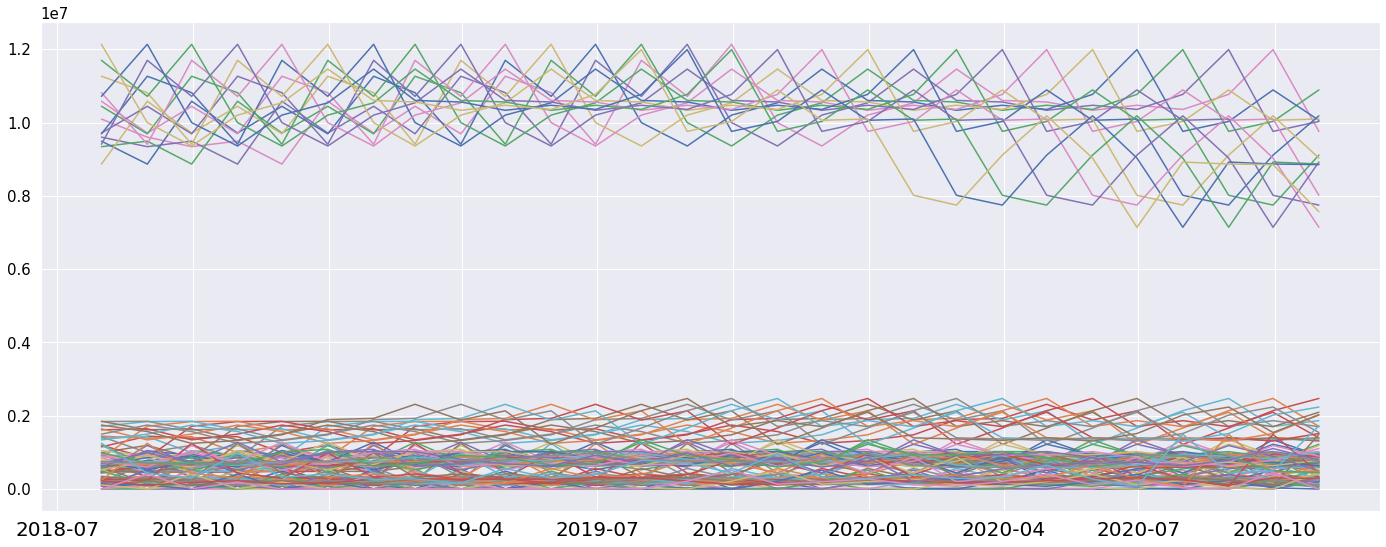

In [102]:
# plot the example time series
!pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# sns.set_context('paper', font_scale=1.3)
# sns.set_style('white')

(fig, ax) = plt.subplots(figsize=(24, 9))

whole_data = train.copy()
target_label = target_column_name
whole_data[target_label] = train[target_column_name]
for g in whole_data.groupby(time_series_id_column_names):
    plt.plot(g[1][time_column_name].values,
             g[1][target_column_name].values, label=g[0])
#plt.legend()
plt.show()

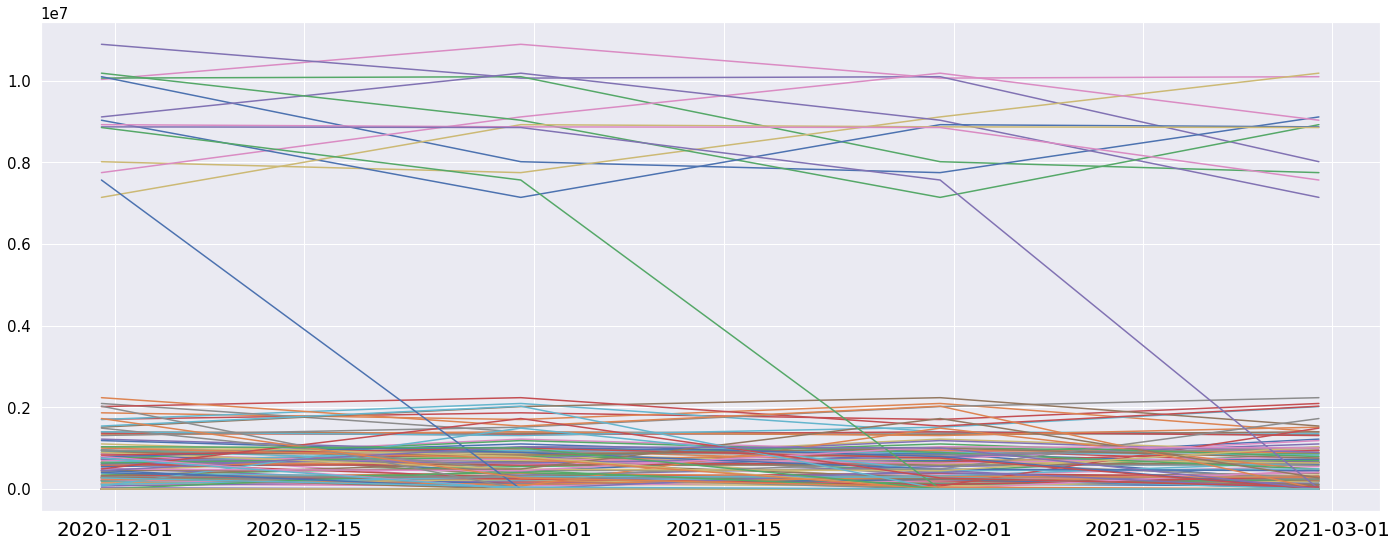

In [103]:
# plot the example time series
(fig, ax) = plt.subplots(figsize=(24, 9))
whole_data = test.copy()
target_label = target_column_name
whole_data[target_label] = test[target_column_name]
for g in whole_data.groupby(time_series_id_column_names):
    plt.plot(g[1][time_column_name].values,
             g[1][target_column_name].values, label=g[0])
#plt.legend()
plt.show()

In [104]:
datastore = ws.get_default_datastore()
datastore.upload_files(files=[output_data_path + 'revregionforecast_train.csv',
                       output_data_path + 'revregionforecast_test.csv'],
                       target_path=blobstore_datadir, overwrite=True,
                       show_progress=True)

Uploading an estimated of 2 files
Uploading ./revregion_outputs/revregionforecast_train.csv
Uploaded ./revregion_outputs/revregionforecast_train.csv, 1 files out of an estimated total of 2
Uploading ./revregion_outputs/revregionforecast_test.csv
Uploaded ./revregion_outputs/revregionforecast_test.csv, 2 files out of an estimated total of 2
Uploaded 2 files


$AZUREML_DATAREFERENCE_478000755a6842c49fc89003cac5b3bd

In [105]:
# Create dataset for training

from azureml.core.dataset import Dataset
train_dataset = \
    Dataset.Tabular.from_delimited_files(path=[(datastore, blobstore_datadir + '/revregionforecast_train.csv')])

display(train_dataset.to_pandas_dataframe().head())
display(train_dataset.to_pandas_dataframe().tail())


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Sub_Region_Code,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Relative_Offset,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,sp500
0,2018-07-31,-31,2017-08-31,-42,Academy,447221,478366,665024,650370,484260,-11,447221,0,0,0,0,19,2471.6500
1,2018-08-31,-30,2017-09-30,-41,Academy,589990,512552,746093,706318,490928,-11,589990,0,22500,0,0,19,2519.3600
2,2018-09-30,-29,2017-10-31,-40,Academy,957862,665024,769661,751822,576836,-11,957861,0,0,0,0,19,2575.2600
3,2018-10-31,-28,2017-11-30,-39,Academy,690428,746093,635716,666480,612230,-11,690429,0,0,0,0,21,2647.5800
4,2018-11-30,-27,2017-12-31,-38,Academy,660692,769661,666543,750285,641106,-11,660692,0,0,0,0,21,2673.6100


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Sub_Region_Code,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Relative_Offset,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,sp500
3355,2020-06-30,-8,2020-09-30,-5,Play Lab,75499,361499,379203,298689,347142,3,74877,852000,0,399275,133091,18,3363.0000
3356,2020-07-31,-7,2020-10-31,-4,Play Lab,750644,377201,363014,363014,399130,3,1492210,626690,851000,676405,225468,18,3269.9600
3357,2020-08-31,-6,2020-11-30,-3,Play Lab,316471,415475,152631,84883,419183,3,447396,450000,0,519217,173072,18,3621.6300
3358,2020-09-30,-5,2020-12-31,-2,Play Lab,148787,516282,74651,57257,424962,3,492145,47000,375000,697455,232485,18,3756.0700
3359,2020-10-31,-4,2021-01-31,-1,Play Lab,209143,348223,87521,65966,480856,3,1727209,1094000,47000,0,0,19,3714.2400


In [106]:
# Featurization Customization examples
'''
featurization_config = FeaturizationConfig()
featurization_config.drop_columns = ['Monthly_Return',
        'sp500_1M_Previous']

# Force the CPWVOL5 feature to be numeric type.
# featurization_config.add_column_purpose('CPWVOL5', 'Numeric')
# Fill missing values in the target column, Revenue, with zeros.

featurization_config.add_transformer_params('Imputer',
        [target_column_name], {'strategy': 'constant', 'fill_value': 0})

# Fill missing values in the Current Opp Period Value column with median value.

featurization_config.add_transformer_params('Imputer',
        ['Current_Opp._Period_Value'], {'strategy': 'median'})
featurization_config.add_transformer_params('Imputer', ['Conversions'],
        {'strategy': 'median'})

# Fill missing values in the sp500 column with forward fill (last value carried forward).

featurization_config.add_transformer_params('Imputer', ['sp500'],
        {'strategy': 'ffill'})
featurization_config.add_transformer_params('Imputer', ['Headcount'],
        {'strategy': 'ffill'})
featurization_config.add_transformer_params('Imputer',
        ['Headcount_Contingent'], {'strategy': 'ffill'})
'''

"\nfeaturization_config = FeaturizationConfig()\nfeaturization_config.drop_columns = ['Monthly_Return',\n        'sp500_1M_Previous']\n\n# Force the CPWVOL5 feature to be numeric type.\n# featurization_config.add_column_purpose('CPWVOL5', 'Numeric')\n# Fill missing values in the target column, Revenue, with zeros.\n\nfeaturization_config.add_transformer_params('Imputer',\n        [target_column_name], {'strategy': 'constant', 'fill_value': 0})\n\n# Fill missing values in the Current Opp Period Value column with median value.\n\nfeaturization_config.add_transformer_params('Imputer',\n        ['Current_Opp._Period_Value'], {'strategy': 'median'})\nfeaturization_config.add_transformer_params('Imputer', ['Conversions'],\n        {'strategy': 'median'})\n\n# Fill missing values in the sp500 column with forward fill (last value carried forward).\n\nfeaturization_config.add_transformer_params('Imputer', ['sp500'],\n        {'strategy': 'ffill'})\nfeaturization_config.add_transformer_params('I

In [107]:
# Train

from azureml.automl.core.forecasting_parameters import ForecastingParameters
lags = 'auto'  # [x for x in range(1,7)]
print ('lags: ', lags)
window_size = 'auto'
forecast_horizon = n_test_periods
print ('window_size: ', window_size, ' forecast_horizon: ',
       forecast_horizon)
forecasting_parameters = ForecastingParameters(  # ,
    time_column_name=time_column_name,
    forecast_horizon=forecast_horizon,
    time_series_id_column_names=time_series_id_column_names,
    target_lags=lags,
    feature_lags='auto',
    target_rolling_window_size=window_size,
    )

    # drop_column_names = ['-1M Pipeline']

automl_config = AutoMLConfig(  # featurization_config,
    task='forecasting',
    debug_log='rev_region_forecast_errors.log',
    primary_metric='normalized_root_mean_squared_error',
    experiment_timeout_hours=4,
    training_data=train_dataset,
    label_column_name=target_column_name,
    compute_target=compute_target,
    enable_early_stopping=True,
    featurization='auto',
    n_cross_validations=5,
    verbosity=logging.INFO,
    max_concurrent_iterations=4,
    max_cores_per_iteration=-1,
    enable_dnn=True,
    forecasting_parameters=forecasting_parameters,
    )

lags:  auto
window_size:  auto  forecast_horizon:  4


In [108]:
# submit a new training run
#'''
remote_run = experiment.submit(automl_config, show_output=True)
remote_run
#'''

Running on remote.
No run_configuration provided, running on cc-bi-ml-devqa01 with default configuration
Running on remote compute: cc-bi-ml-devqa01
Parent Run ID: AutoML_bd6d5d96-c844-4b35-9b75-8fa474fb422e

Current status: DatasetFeaturization. Completed featurizing the dataset.
Current status: ModelSelection. Beginning model selection.
Heuristic parameters: Target_Lag = '[0]', Target_Rolling_Window = '0'.


****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Frequency detection
STATUS:       PASSED
DESCRIPTION:  The time series was analyzed, all data points are aligned with detected frequency.
              

****************************************************************************************************

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
              Learn more about missing value imputa

Experiment,Id,Type,Status,Details Page,Docs Page
RevenueForecastRegion,AutoML_bd6d5d96-c844-4b35-9b75-8fa474fb422e,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [109]:
# If you need to retrieve a run that already started, use the following code
'''
from azureml.train.automl.run import AutoMLRun
remote_run = AutoMLRun(experiment=experiment,
                       run_id='AutoML_05cc3718-65e3-4122-ae72-c5def53c3b03'  #Run 3
                       )
'''                   

"\nfrom azureml.train.automl.run import AutoMLRun\nremote_run = AutoMLRun(experiment=experiment,\n                       run_id='AutoML_05cc3718-65e3-4122-ae72-c5def53c3b03'  #Run 3\n                       )\n"

In [118]:
rr = remote_run.wait_for_completion()
run_id = rr.get('runId')
run_datetime = rr.get('endTimeUtc')
rr

{'runId': 'AutoML_bd6d5d96-c844-4b35-9b75-8fa474fb422e',
 'target': 'cc-bi-ml-devqa01',
 'status': 'Completed',
 'startTimeUtc': '2021-02-15T21:15:12.91887Z',
 'endTimeUtc': '2021-02-15T21:48:17.390252Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'normalized_root_mean_squared_error',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '5',
  'target': 'cc-bi-ml-devqa01',
  'AMLSettingsJsonString': '{"path":null,"name":"RevenueForecastRegion","subscription_id":"db61fd47-db56-45e3-844f-1b1f5c47990a","resource_group":"rg-bi-automl-devqa01","workspace_name":"mlw-bi-automl-devqa01","region":"westus","compute_target":"cc-bi-ml-devqa01","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"iterations":1000,"primary_metric":"normalized_root_mean_squared_error","task_type":"regression","data_script":null,"validation_size":0.0,"n_cross_val

In [119]:
# Retrieve the Best Model

(best_run, fitted_model) = remote_run.get_output()
print ('Best Run Model: ', best_run)
print (fitted_model.steps)
model_name = best_run.properties['model_name']
print ('Model Name: ', model_name)

Package:azureml-automl-runtime, training version:1.21.0, current version:1.20.0
Package:azureml-core, training version:1.21.0.post1, current version:1.20.0
Package:azureml-dataprep, training version:2.8.2, current version:2.7.3
Package:azureml-dataprep-native, training version:28.0.0, current version:27.0.0
Package:azureml-dataprep-rslex, training version:1.6.0, current version:1.5.0
Package:azureml-dataset-runtime, training version:1.21.0, current version:1.20.0
Package:azureml-defaults, training version:1.21.0, current version:1.20.0
Package:azureml-interpret, training version:1.21.0, current version:1.20.0
Package:azureml-pipeline-core, training version:1.21.0, current version:1.20.0
Package:azureml-telemetry, training version:1.21.0, current version:1.20.0
Package:azureml-train-automl-client, training version:1.21.0, current version:1.20.0
Package:azureml-train-automl-runtime, training version:1.21.0, current version:1.20.0


Best Run Model:  Run(Experiment: RevenueForecastRegion,
Id: AutoML_bd6d5d96-c844-4b35-9b75-8fa474fb422e_532,
Type: azureml.scriptrun,
Status: Completed)
[('timeseriestransformer', TimeSeriesTransformer(featurization_config=None,
                      pipeline_type=<TimeSeriesPipelineType.FULL: 1>)), ('StandardScalerWrapper', <azureml.automl.runtime.shared.model_wrappers.StandardScalerWrapper object at 0x7ff43566b048>), ('RandomForestRegressor', RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.9, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=0.001953125,
                      min_samples_split=0.0037087774117744725,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False))]
Model

In [120]:
# Transparency
# View updated featurization summary

featurization_summary = fitted_model.named_steps['timeseriestransformer'
        ].get_featurization_summary()

# View the featurization summary as a pandas dataframe

pd.DataFrame.from_records(featurization_summary)


,RawFeatureName,TypeDetected,Dropped,EngineeredFeatureCount,Transformations
0,Relative_Snapshot_Month_Offset,Numeric,No,2,"[MedianImputer, ImputationMarker]"
1,Relative_Month_Offset,Numeric,No,2,"[MedianImputer, ImputationMarker]"
2,Pipeline,Numeric,No,2,"[MedianImputer, ImputationMarker]"
3,Pipeline_3_Month_Rolling_Avg,Numeric,No,2,"[MedianImputer, ImputationMarker]"
4,Pipeline_3M_Forward_Avg,Numeric,No,2,"[MedianImputer, ImputationMarker]"
5,Pipeline_6M_Forward_Avg,Numeric,No,2,"[MedianImputer, ImputationMarker]"
6,Pipeline_6M_Rolling_Avg,Numeric,No,2,"[MedianImputer, ImputationMarker]"
7,Current_Opp._Period_Value,Numeric,No,2,"[MedianImputer, ImputationMarker]"
8,Conversions,Numeric,No,2,"[MedianImputer, ImputationMarker]"
9,Pipeline_Trend,Numeric,No,2,"[MedianImputer, ImputationMarker]"


In [121]:
# Explore the results

from azureml.widgets import RunDetails
RunDetails(best_run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [122]:
# FORECASTING

X_test = test.copy()
y_test = X_test.pop(target_column_name).values

In [123]:
X_test.tail()

,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Sub_Region_Code,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Relative_Offset,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,sp500
3838,2021-02-28,0,2021-05-31,3,North America,4864571,8071729,4513339,3658196,8097607,3,0,0,0,0,301,0.0000
3479,2020-11-30,-3,2021-02-28,0,Play Lab,275169,540285,124625,96723,632525,3,0,5000,723135,241045,20,3934.8300
3599,2020-12-31,-2,2021-03-31,1,Play Lab,122759,595206,51225,39585,702894,3,0,0,0,0,20,0.0000
3719,2021-01-31,-1,2021-04-30,2,Play Lab,101923,264827,71089,59312,576871,3,0,0,0,0,20,0.0000
3839,2021-02-28,0,2021-05-31,3,Play Lab,105564,218797,87689,65142,579876,3,0,0,0,0,20,0.0000


In [124]:
# forecast returns the predictions and the featurized data, aligned to X_test.
# This contains the assumptions that were made in the forecast
# The featurized data, aligned to y, will also be returned.
# This contains the assumptions that were made in the forecast
# and helps align the forecast to the original data

y_predictions, X_trans = fitted_model.forecast(X_test)

In [125]:
# from forecasting_helper import align_outputs

df_all = align_outputs(y_predictions, X_trans, X_test, y_test,
                       target_column_name)
df_all.tail(20)

,Snapshot_Date_Short,Relative_Offset,Sub_Region_Code,predicted,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,sp500,Revenue
460,2020-11-30,3,Europe,1717592.9841,-3,2021-02-28,0,1638585,1631257,1067111,827507,1775004,903328,724857,5215971,1738657,70,3934.8300,411
461,2020-12-31,3,Europe,1532352.1111,-2,2021-03-31,1,1481455,1783433,1217632,926046,1843677,0,0,0,0,70,0.0000,0
462,2021-01-31,3,Europe,1432057.7472,-1,2021-04-30,2,1156305,1692098,1011543,683904,1811629,0,0,0,0,70,0.0000,0
463,2021-02-28,3,Europe,1576764.0977,0,2021-05-31,3,1526941,1668875,1103380,794904,1747609,0,0,0,0,70,0.0000,0
464,2020-11-30,3,Global,184344.3432,-3,2021-02-28,0,456105,456848,365120,365120,253298,0,0,1160139,386713,21,3934.8300,12130
465,2020-12-31,3,Global,522882.8499,-2,2021-03-31,1,940964,774254,520993,288611,393511,0,0,0,0,22,0.0000,0
466,2021-01-31,3,Global,326018.7140,-1,2021-04-30,2,526629,342782,407413,229698,238291,0,0,0,0,22,0.0000,0
467,2021-02-28,3,Global,366726.5103,0,2021-05-31,3,395334,439330,268675,145630,304131,0,0,0,0,22,0.0000,0
468,2020-11-30,3,Japan,689390.0897,-3,2021-02-28,0,541685,534599,479046,267083,711874,0,96000,2772328,924109,35,3934.8300,0
469,2020-12-31,3,Japan,791000.0042,-2,2021-03-31,1,784867,620107,510967,284987,762530,0,0,0,0,34,0.0000,0


In [126]:
# Evaluate
# To evaluate the accuracy of the forecast, we'll compare against the actual sales quantities for some select metrics, included the mean absolute percentage error (MAPE).

# We'll add predictions and actuals into a single dataframe for convenience in calculating the metrics.

# assign_dict = {'predicted': y_predictions, target_column_name: y_test}
# df_all = X_test.assign(**assign_dict)
# df_all

[Test data scores]
root_mean_squared_log_error:   5.133
normalized_median_absolute_error:   0.001
normalized_root_mean_squared_log_error:   0.317
normalized_mean_absolute_error:   0.030
r2_score:   0.749
explained_variance:   0.760
mean_absolute_error:   327994.651
normalized_root_mean_squared_error:   0.120
spearman_correlation:   0.700
mean_absolute_percentage_error:   4432.661
root_mean_squared_error:   1307054.261
median_absolute_error:   12783.352


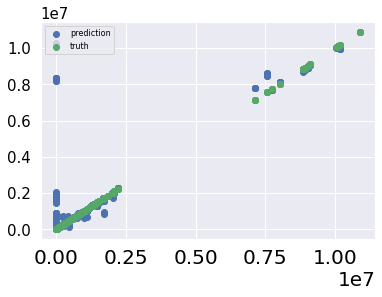

In [127]:
from azureml.automl.core.shared import constants
from azureml.automl.runtime.shared.score import scoring
from matplotlib import pyplot as plt

# use automl scoring module

scores = scoring.score_regression(
    y_test=df_all[target_column_name],
    y_pred=df_all['predicted'],
    metrics=list(constants.Metric.SCALAR_REGRESSION_SET))

print('[Test data scores]')
for key, value in scores.items():    
    print('{}:   {:.3f}'.format(key, value))
    
# Plot outputs

%matplotlib inline
test_pred = plt.scatter(df_all[target_column_name], df_all['predicted'], color='b')
test_test = plt.scatter(df_all[target_column_name], df_all[target_column_name], color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()

In [129]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df_all.groupby('End_of_Month').apply(lambda df: \
        pd.Series({'MAPE': MAPE(df[target_column_name], df['predicted'
        ]), 'RMSE': np.sqrt(mean_squared_error(df[target_column_name],
        df['predicted'])),
        'MAE': mean_absolute_error(df[target_column_name],
        df['predicted']),
        'R2_SCORE': r2_score(df[target_column_name],
        df['predicted'])}))

,MAPE,RMSE,MAE,R2_SCORE
End_of_Month,,,,
2019-12-31,1.0842,14037.6512,8239.0287,1.0000
2020-01-31,0.6312,6067.0412,4629.0737,1.0000
2020-02-29,0.5618,4383.9052,3633.2743,1.0000
2020-03-31,1.0242,23115.5565,11903.0450,0.9999
2020-04-30,4.6672,39245.2163,21624.4143,0.9998
2020-05-31,3.8535,29716.8922,18591.2901,0.9998
2020-06-30,1.2970,20627.7887,11669.5398,0.9999
2020-07-31,3.4188,82275.2197,42495.8425,0.9993
2020-08-31,0.9676,42553.0777,19025.0348,0.9998


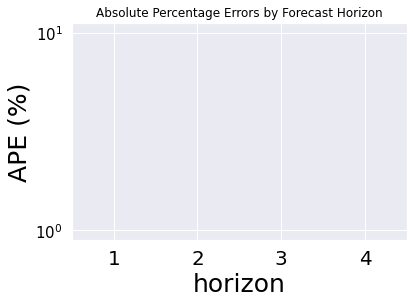

In [131]:
df_all_APE = df_all.assign(APE=APE(df_all[target_column_name], df_all['predicted']))
APEs = [df_all_APE[df_all['End_of_Month'] == h].APE.values for h in range(1, forecast_horizon + 1)]

%matplotlib inline
plt.boxplot(APEs)
plt.yscale('log')
plt.xlabel('horizon')
plt.ylabel('APE (%)')
plt.title('Absolute Percentage Errors by Forecast Horizon')

plt.show()

In [132]:
# Confidence intervals

quantiles =  fitted_model.forecast_quantiles(X_test)
quantiles

,Snapshot_Date_Short,Relative_Offset,Sub_Region_Code,0.5
0,2020-11-30,-11,Academy,786759.6755
1,2020-12-31,-11,Academy,602574.3648
2,2021-01-31,-11,Academy,755539.4505
3,2021-02-28,-11,Academy,1222418.0830
4,2020-11-30,-11,Centers of Excellence,124401.1488
...,...,...,...,...
475,2021-02-28,3,North America,8362273.9263
476,2020-11-30,3,Play Lab,712831.7288
477,2020-12-31,3,Play Lab,771521.7535
478,2021-01-31,3,Play Lab,833140.1453


In [133]:
# specify which quantiles you would like 

fitted_model.quantiles = [0.01, 0.5, 0.8, 0.95]

# use forecast_quantiles function, not the forecast() one

y_pred_quantiles =  fitted_model.forecast_quantiles(X_test)

# quantile forecasts returned in a Dataframe along with the time and time series id columns 

y_pred_quantiles

,Snapshot_Date_Short,Relative_Offset,Sub_Region_Code,0.01,0.5,0.8,0.95
0,2020-11-30,-11,Academy,214703.0699,786759.6755,993717.1093,1191234.6009
1,2020-12-31,-11,Academy,-206435.8454,602574.3648,895256.3745,1174588.2898
2,2021-01-31,-11,Academy,-235291.6553,755539.4505,1114000.2408,1456110.5715
3,2021-02-28,-11,Academy,78304.8717,1222418.0830,1636332.9505,2031367.9336
4,2020-11-30,-11,Centers of Excellence,-447655.4568,124401.1488,331358.5826,528876.0742
...,...,...,...,...,...,...,...
475,2021-02-28,3,North America,7218160.7150,8362273.9263,8776188.7939,9171223.7769
476,2020-11-30,3,Play Lab,140775.1232,712831.7288,919789.1626,1117306.6541
477,2020-12-31,3,Play Lab,-37488.4567,771521.7535,1064203.7631,1343535.6785
478,2021-01-31,3,Play Lab,-157690.9604,833140.1453,1191600.9357,1533711.2664


In [134]:
# Get the column index list in the right order

cols_sort_list = list(df_all.columns) + ['Revenue_Forecast']
display(cols_sort_list)
display(df_all.head())
display(train.head())

['Snapshot_Date_Short',
 'Relative_Offset',
 'Sub_Region_Code',
 'predicted',
 'Relative_Snapshot_Month_Offset',
 'End_of_Month',
 'Relative_Month_Offset',
 'Pipeline',
 'Pipeline_3_Month_Rolling_Avg',
 'Pipeline_3M_Forward_Avg',
 'Pipeline_6M_Forward_Avg',
 'Pipeline_6M_Rolling_Avg',
 'Current_Opp._Period_Value',
 'Conversions',
 'Pipeline_Trend',
 'Pipeline_Trend_Avg',
 'Billable_Headcount',
 'sp500',
 'Revenue',
 'Revenue_Forecast']

,Snapshot_Date_Short,Relative_Offset,Sub_Region_Code,predicted,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,sp500,Revenue
0,2020-11-30,-11,Academy,786759.6755,-3,2019-12-31,-14,789694,1015626,715665,873804,873788,84000,123900,418575,139525,25,3230.7800,789694
1,2020-12-31,-11,Academy,602574.3648,-2,2020-01-31,-13,600747,767735,859909,912493,831827,228000,235944,356917,118972,24,3225.5200,600747
2,2021-01-31,-11,Academy,755539.4505,-1,2020-02-29,-12,756555,715665,971135,955772,848230,270100,100,368410,122803,24,2954.2200,756555
3,2021-02-28,-11,Academy,1222418.0830,0,2020-03-31,-11,1222424,859909,1031943,932344,937767,157000,27093,2411257,803752,22,2584.5900,1222424
4,2020-11-30,-11,Centers of Excellence,124401.1488,-3,2019-12-31,-14,120948,218073,154317,185015,249998,290000,1306,771813,257271,8,3230.7800,120948


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Sub_Region_Code,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Relative_Offset,Revenue,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,sp500
0,2018-07-31,-31,2017-08-31,-42,Academy,447221,478366,665024,650370,484260,-11,447221,0,0,0,0,19,2471.6500
120,2018-08-31,-30,2017-09-30,-41,Academy,589990,512552,746093,706318,490928,-11,589990,0,22500,0,0,19,2519.3600
240,2018-09-30,-29,2017-10-31,-40,Academy,957862,665024,769661,751822,576836,-11,957861,0,0,0,0,19,2575.2600
360,2018-10-31,-28,2017-11-30,-39,Academy,690428,746093,635716,666480,612230,-11,690429,0,0,0,0,21,2647.5800
480,2018-11-30,-27,2017-12-31,-38,Academy,660692,769661,666543,750285,641106,-11,660692,0,0,0,0,21,2673.6100


In [137]:
# Merge df_all with train

from functools import reduce

nan_value = 0
merge_dfs = [train, df_all]

final_merge_df = train.append(df_all,
                              ignore_index=True,
                              sort=False).sort_values(by=sort_cols)
coerce_df_columns_to_numeric(final_merge_df)

final_merge_df = final_merge_df.replace(np.nan, 0, regex=True)

# merge_df = merge_df.query('Fin_Entity_ID!='SGP'') # Exclude Singapore rows
# final_merge_df.sort_values(by=['Relative_Offset','Fin_Entity_ID']).reset_index(drop=True) and Relative_Month_Offset >= 0
# merge_df.drop(columns=['Current_Opp._Period_Value','Conversions'], axis=1, inplace = True)
# create new column

final_merge_df['Revenue_Forecast'] = np.where(final_merge_df['predicted'
        ] != 0, final_merge_df['predicted'], final_merge_df['Revenue'])
final_merge_df['Relative_Month_Offset'] = \
    round((final_merge_df['End_of_Month'] - current_eom)
          / np.timedelta64(1, 'M'), 0).astype(int)
final_merge_df['End_of_Month'] = \
    pd.to_datetime(final_merge_df['End_of_Month'])#.dt.date

#final_merge_df['origin'] = pd.to_datetime(final_merge_df['origin'
#        ])#.dt.date

final_merge_df['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df['Snapshot_Date_Short'])#.dt.date
# sort using original cols_sort_list
final_merge_df = \
    final_merge_df.sort_values(by=sort_cols).reset_index(drop=True)
final_merge_df = final_merge_df.reindex(columns=cols_sort_list)

# add revenue vs predicted variance
final_merge_df['Diff'] = np.where(final_merge_df['Relative_Month_Offset'] < 0, final_merge_df['Revenue'] - final_merge_df['predicted'], np.nan)
final_merge_df['Diff%'] = np.where(final_merge_df['Relative_Month_Offset'] < 0, round(final_merge_df['Diff'] / final_merge_df['predicted'] * 100, ndigits=4), np.nan)
final_merge_df['Diff'].where(final_merge_df['predicted'] != 0, np.nan, inplace = True)
final_merge_df['Diff%'].where(final_merge_df['predicted'] != 0, np.nan, inplace = True)
final_merge_df['Diff%'] = round(final_merge_df['Diff%'], ndigits=4)
final_merge_df['Run_ID'] = run_id
final_merge_df['Run_Date'] = pd.to_datetime(run_datetime).normalize().date()
final_merge_df['Run_Date'] = pd.to_datetime(final_merge_df['Run_Date'])#.dt.date


print(' final_merge_df: ')
final_merge_df.info()
final_merge_df.to_csv(output_data_path + 'final_merge_df.csv',
                      index=False)
final_merge_df.to_parquet(output_data_path + 'final_merge_df.parquet',
                          index=None)
#final_merge_df
display(final_merge_df.tail(28))
#final_merge_df  # .query('Fin_Entity_ID==@entity_debug')

 final_merge_df: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840 entries, 0 to 3839
Data columns (total 24 columns):
Snapshot_Date_Short               3840 non-null datetime64[ns]
Relative_Offset                   3840 non-null int64
Sub_Region_Code                   3840 non-null object
predicted                         3840 non-null int64
Relative_Snapshot_Month_Offset    3840 non-null int64
End_of_Month                      3840 non-null datetime64[ns]
Relative_Month_Offset             3840 non-null int64
Pipeline                          3840 non-null int64
Pipeline_3_Month_Rolling_Avg      3840 non-null int64
Pipeline_3M_Forward_Avg           3840 non-null int64
Pipeline_6M_Forward_Avg           3840 non-null int64
Pipeline_6M_Rolling_Avg           3840 non-null int64
Current_Opp._Period_Value         3840 non-null int64
Conversions                       3840 non-null int64
Pipeline_Trend                    3840 non-null int64
Pipeline_Trend_Avg                3840 non-nul

,Snapshot_Date_Short,Relative_Offset,Sub_Region_Code,predicted,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Pipeline,Pipeline_3_Month_Rolling_Avg,Pipeline_3M_Forward_Avg,Pipeline_6M_Forward_Avg,Pipeline_6M_Rolling_Avg,Current_Opp._Period_Value,Conversions,Pipeline_Trend,Pipeline_Trend_Avg,Billable_Headcount,sp500,Revenue,Revenue_Forecast,Diff,Diff%,Run_ID,Run_Date
3812,2021-02-28,0,Global,110567,0,2021-02-28,0,110586,168931,344414,306544,104648,0,0,1160139,386713,21,3934.8300,12130,110567,nan,nan,AutoML_bd6d5d96-c844-4b35-9b75-8fa474fb422e,2021-02-15
3813,2021-02-28,0,Japan,791165,0,2021-02-28,0,798782,853762,902498,675744,872052,0,96000,2772328,924109,35,3934.8300,0,791165,nan,nan,AutoML_bd6d5d96-c844-4b35-9b75-8fa474fb422e,2021-02-15
3814,2021-02-28,0,North America,8330117,0,2021-02-28,0,7947833,8123485,9099483,6806411,8218102,8895000,4238228,26224195,8741398,310,3934.8300,0,8330117,nan,nan,AutoML_bd6d5d96-c844-4b35-9b75-8fa474fb422e,2021-02-15
3815,2021-02-28,0,Play Lab,657819,0,2021-02-28,0,603512,940955,384780,236234,806225,0,5000,723135,241045,20,3934.8300,272411,657819,nan,nan,AutoML_bd6d5d96-c844-4b35-9b75-8fa474fb422e,2021-02-15
3816,2021-02-28,1,Academy,919874,0,2021-03-31,1,1005739,831198,1005739,1005739,844421,0,0,0,0,17,0.0000,1005739,919874,nan,nan,AutoML_bd6d5d96-c844-4b35-9b75-8fa474fb422e,2021-02-15
3817,2021-02-28,1,Centers of Excellence,427691,0,2021-03-31,1,731937,530415,611560,504528,375342,0,0,0,0,21,0.0000,0,427691,nan,nan,AutoML_bd6d5d96-c844-4b35-9b75-8fa474fb422e,2021-02-15
3818,2021-02-28,1,China,910517,0,2021-03-31,1,1000735,762153,823368,594201,802592,0,0,0,0,26,0.0000,0,910517,nan,nan,AutoML_bd6d5d96-c844-4b35-9b75-8fa474fb422e,2021-02-15
3819,2021-02-28,1,Europe,1887523,0,2021-03-31,1,1838570,1924797,1668875,1218479,1929243,0,0,0,0,70,0.0000,0,1887523,nan,nan,AutoML_bd6d5d96-c844-4b35-9b75-8fa474fb422e,2021-02-15
3820,2021-02-28,1,Global,348487,0,2021-03-31,1,394174,148183,439330,291974,130883,0,0,0,0,22,0.0000,0,348487,nan,nan,AutoML_bd6d5d96-c844-4b35-9b75-8fa474fb422e,2021-02-15
3821,2021-02-28,1,Japan,883156,0,2021-03-31,1,925672,827633,910175,576189,868436,0,0,0,0,34,0.0000,0,883156,nan,nan,AutoML_bd6d5d96-c844-4b35-9b75-8fa474fb422e,2021-02-15


In [142]:
# pivot by EOM1, Fin_Entity_ID
pd.set_option('display.float_format', lambda x: '%.1f' % x) #


cols = ['Pipeline','Revenue','predicted','Diff','Diff%']
final_cond = 'Relative_Offset >= -@relative_offset_periods and Relative_Snapshot_Month_Offset > -@n_test_periods'
final_merge_df1 = final_merge_df.query(final_cond)
final_merge_df1['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df1['Snapshot_Date_Short']).dt.date
final_merge_df1['End_of_Month'] = pd.to_datetime(final_merge_df1['End_of_Month']).dt.date
final_merge_pivot1 = final_merge_df1.pivot_table(index=['Snapshot_Date_Short','End_of_Month'], #columns='Relative_Offset',
        values=cols, aggfunc={'predicted':np.sum,'Pipeline':np.sum,'Revenue':np.sum,'Diff':np.sum, 'Diff%':np.mean}, margins=None)
#final_merge_pivot1['End_of_Month'] = pd.to_datetime(final_merge_pivot1['End_of_Month']).dt.date
# final_merge_pivot1.reset_index(level=final_merge_pivot1.index.names)

# show_stats(revtime_pivot1)
final_merge_pivot1.sort_values(by=['Snapshot_Date_Short','End_of_Month'],inplace=True)
#reorder columns
cols_order = [2,3,4,0,1]
final_merge_pivot1 = final_merge_pivot1[[final_merge_pivot1.columns[i] for i in cols_order]]

# set ALL float columns to '${:,.2f}' formatting (including the percentage)
#format_dict = {col_name: '${:,.1f}' for col_name in final_merge_pivot1.select_dtypes(float).columns}
# override the percentage column
format_dict = {col_name: '{:,}' for col_name in final_merge_pivot1.columns}
format_dict['Diff%'] = '{:.2f}'


# Format with commas and round off to two decimal places in pandas 
# final_merge_pivot1 = final_merge_pivot1[[['Snapshot_Date_Short','End_of_Month']+cols]]
final_merge_pivot1.tail(30).style.format(format_dict)#.style.format('{:,}')# .query('(End_of_Month == @current_eom)')

In [144]:
#!pip install xlsxwriter
#import xlsxwriter
# Read existing file, create if not exists with header, then append new data
final_cols = ['Run_Date','Snapshot_Date_Short','End_of_Month','Sub_Region_Code','Pipeline','Revenue','predicted','Diff','Diff%']
revenue_predict_new = final_merge_df.query(final_cond)[final_cols].copy()
#revenue_predict_new.insert(1, 'Forecast_Date', str(today.date()))
revenue_predict_new = revenue_predict_new.sort_values(by=['Run_Date','Snapshot_Date_Short','End_of_Month','Sub_Region_Code']).reset_index(drop=True)
print('new:')
print(revenue_predict_new.info(verbose=True))
#reorder columns
#cols_order = [7,0,1,2,3,4,5,6]
#revenue_predict_new = revenue_predict_new[[revenue_predict_new.columns[i] for i in cols_order]]
filename = output_data_path + './revenue_region_prediction.csv'

if os.path.isfile(filename):
    revenue_predict_hist = pd.read_csv(filename, parse_dates=['Run_Date','Snapshot_Date_Short','End_of_Month','Sub_Region_Code'])
    print('history:')
    print(revenue_predict_hist.info(verbose=True))
    revenue_predict = pd.merge(revenue_predict_hist, revenue_predict_new, how='left', on=['Run_Date','Snapshot_Date_Short','End_of_Month','Sub_Region_Code'])
    print('revenue_predict:')
    print(revenue_predict.info(verbose=True))
    #revenue_predict['End_of_Month'] = pd.to_datetime(revenue_predict['End_of_Month'])
    #revenue_predict = revenue_predict.reset_index(drop=True)
else:
    revenue_predict = revenue_predict_new.copy()
    
revenue_predict = revenue_predict.sort_values(by=['Run_Date','Snapshot_Date_Short','End_of_Month','Sub_Region_Code']).reset_index(drop=True)
revenue_predict.to_csv(filename, header=True, index=False)
display(revenue_predict)
# revenue_predict.to_excel(output_data_path + r'./revenue_prediction.xlsx', \
#              sheet_name=str(today.date()), header=True, engine='xlsxwriter', index=False)  

new:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 9 columns):
Run_Date               480 non-null datetime64[ns]
Snapshot_Date_Short    480 non-null datetime64[ns]
End_of_Month           480 non-null datetime64[ns]
Sub_Region_Code        480 non-null object
Pipeline               480 non-null int64
Revenue                480 non-null int64
predicted              480 non-null int64
Diff                   400 non-null float64
Diff%                  400 non-null float64
dtypes: datetime64[ns](3), float64(2), int64(3), object(1)
memory usage: 33.9+ KB
None


,Run_Date,Snapshot_Date_Short,End_of_Month,Sub_Region_Code,Pipeline,Revenue,predicted,Diff,Diff%
0,2021-02-15,2020-11-30,2019-12-31,Academy,789694,789694,786759,2935.0,0.4
1,2021-02-15,2020-11-30,2019-12-31,Centers of Excellence,120948,120948,124401,-3453.0,-2.8
2,2021-02-15,2020-11-30,2019-12-31,China,620791,620791,621179,-388.0,-0.1
3,2021-02-15,2020-11-30,2019-12-31,Europe,1707656,1707656,1708311,-655.0,-0.0
4,2021-02-15,2020-11-30,2019-12-31,Global,513784,513784,491894,21890.0,4.5
...,...,...,...,...,...,...,...,...,...
475,2021-02-15,2021-02-28,2021-05-31,Europe,1526941,0,1576764,nan,nan
476,2021-02-15,2021-02-28,2021-05-31,Global,395334,0,366726,nan,nan
477,2021-02-15,2021-02-28,2021-05-31,Japan,821812,0,868791,nan,nan
478,2021-02-15,2021-02-28,2021-05-31,North America,4864571,0,8362273,nan,nan


In [145]:
from azureml.interpret import ExplanationClient
client = ExplanationClient.from_run(best_run)
engineered_explanations = client.download_model_explanation(raw=False)
print(engineered_explanations.get_feature_importance_dict())
print("You can visualize the engineered explanations under the 'Explanations (preview)' tab in the AutoML run at:-\n" + best_run.get_portal_url())
raw_explanations = client.download_model_explanation(raw=True)
print(raw_explanations.get_feature_importance_dict())
print("You can visualize the raw explanations under the 'Explanations (preview)' tab in the AutoML run at:-\n" + best_run.get_portal_url())

{'Pipeline_3_Month_Rolling_Avg': 1929890.9156771663, 'Pipeline': 309334.8853501865, 'Pipeline_6M_Rolling_Avg': 158364.71540756503, 'Billable_Headcount': 31793.200910175943, 'Relative_Month_Offset': 31516.989990088943, 'Pipeline_6M_Forward_Avg': 20930.180878084815, 'grain_Relative_Offset': 10641.071682544682, 'Pipeline_3M_Forward_Avg': 10522.493007445644, 'Conversions': 10118.726491051602, 'Pipeline_Trend': 8784.00576531744, 'grain_Sub_Region_Code': 5303.789505856068, 'End_of_Month_Month': 3379.941904387576, 'Current_Opp._Period_Value': 3255.1585107316123, 'sp500': 2980.420069538755, 'End_of_Month_DayOfWeek': 1392.939625526225, 'End_of_Month_Day': 1343.526306997333, 'Relative_Snapshot_Month_Offset': 697.712692747631, 'End_of_Month_DayOfYear': 449.5613706500361, '_automl_week': 277.08422018838905, '_automl_month': 234.8331759097961, '_automl_half': 222.3672755606168, '_automl_wday': 168.02760332981475, '_automl_qday': 111.84128417261189, '_automl_quarter': 95.86753109402655, '_automl_day

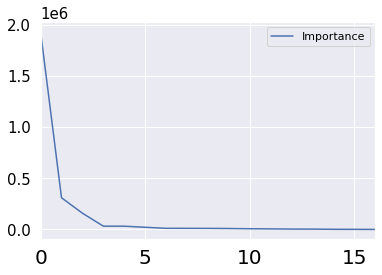

In [146]:
feature_imp_dict = pd.DataFrame(raw_explanations.get_feature_importance_dict().items())
feature_imp_dict.columns = ['Feature','Importance']
feature_imp_dict.plot()

In [147]:
# multiple line plot
# Set themes

import matplotlib.pyplot as plt

# plot

sns.set()
sns.set_context('poster')  # In order of relative size they are: paper, notebook, talk, and poster. Notebook is default
sns.set(style='whitegrid')  # Seaborn has five built-in themes to style its plots: darkgrid, whitegrid, dark, white, and ticks.

# Save a palette to a variable:

palette = sns.color_palette('Accent', 8)

# Use palplot and pass in the variable:
# sns.palplot(palette)
# Set the palette using the name of a palette:
# sns.set_palette(palette)
bg_color = 'white'
sns.set(rc={"font.style":"normal",
            #"axes.facecolor":bg_color,
            #"figure.facecolor":bg_color,
            "text.color":"black",
            "xtick.color":"black",
            "ytick.color":"black",
            "axes.labelcolor":"black",
            "axes.grid":True,
            'axes.labelsize':25,
            'figure.figsize':(12.0, 8.0),
            'xtick.labelsize':20,
            'font.size':15,
            'ytick.labelsize':15})

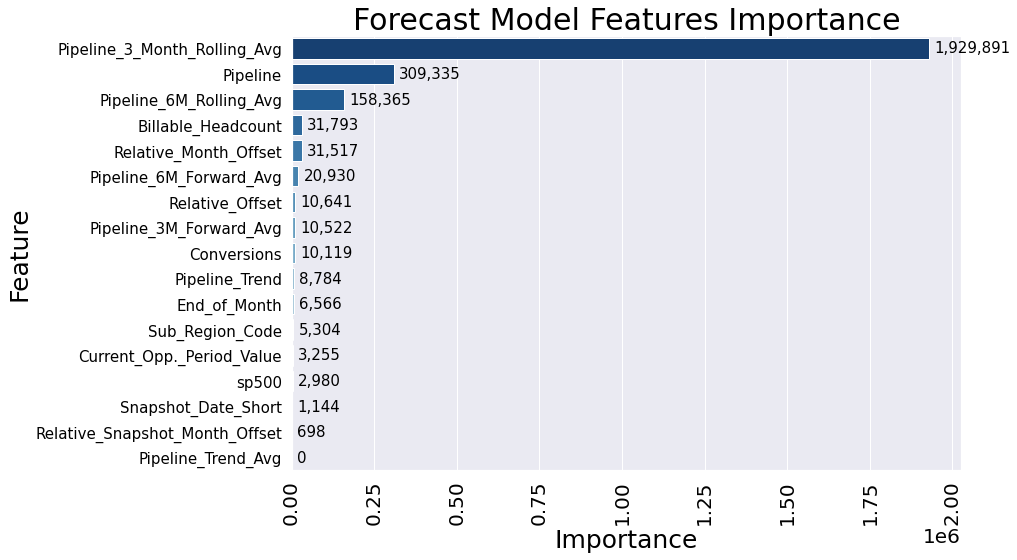

In [148]:
#(fig, ax) = plt.subplots(figsize=(24, 9))
g = sns.barplot(   #alpha=0.50,
    y='Feature',
    x='Importance',
    ci=None,
    data=feature_imp_dict,
    #color='skyblue'
    #orient='horizontal'
    palette='Blues_r',
    #ax=ax,
    )
plt.xticks(rotation=90)
plt.title('Forecast Model Features Importance', fontsize=30)
for p in g.patches:
    g.annotate(
        '{:,.0f}'.format(p.get_width()),
        xy=(p.get_width(), p.get_y() + p.get_height()/2),
        ha='left',
        va='center',
        xytext=(5, 0),
        #color = 'white',
        textcoords='offset points',
        )
#g.legend(['Revenue', 'Forecast'], facecolor='w')
plt.show()

In [153]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

revenue_predict.query("Diff != 0").groupby(
    "End_of_Month"
).apply(
    lambda df: pd.Series(
        {
            "Mean Absolute Percent Error(MAPE)": MAPE(
                df[target_column_name], df["predicted"]
            ),
            "Root Mean Square Error (RMSE)": np.sqrt(
                mean_squared_error(df[target_column_name], df["predicted"])
            ),
            "Mean Absolute Error (MAE)": mean_absolute_error(
                df[target_column_name], df["predicted"]
            ),
        }
    )
)


,Mean Absolute Percent Error(MAPE),Root Mean Square Error (RMSE),Mean Absolute Error (MAE)
End_of_Month,,,
2019-12-31,1.1,14037.9,8239.1
2020-01-31,0.6,6067.2,4628.9
2020-02-29,0.6,4383.9,3633.4
2020-03-31,1.0,23115.8,11903.1
2020-04-30,4.7,39244.9,21624.1
2020-05-31,3.9,29717.1,18591.2
2020-06-30,1.3,20627.9,11669.5
2020-07-31,3.4,82275.5,42496.1
2020-08-31,1.0,42553.3,19024.7


In [149]:
# multiple line plot
# Set themes

import matplotlib.pyplot as plt

# plot

sns.set()
sns.set_context('poster')  # In order of relative size they are: paper, notebook, talk, and poster. Notebook is default
sns.set(style='whitegrid')  # Seaborn has five built-in themes to style its plots: darkgrid, whitegrid, dark, white, and ticks.

# Save a palette to a variable:

palette = sns.color_palette('Accent', 8)

# Use palplot and pass in the variable:
# sns.palplot(palette)
# Set the palette using the name of a palette:
# sns.set_palette(palette)

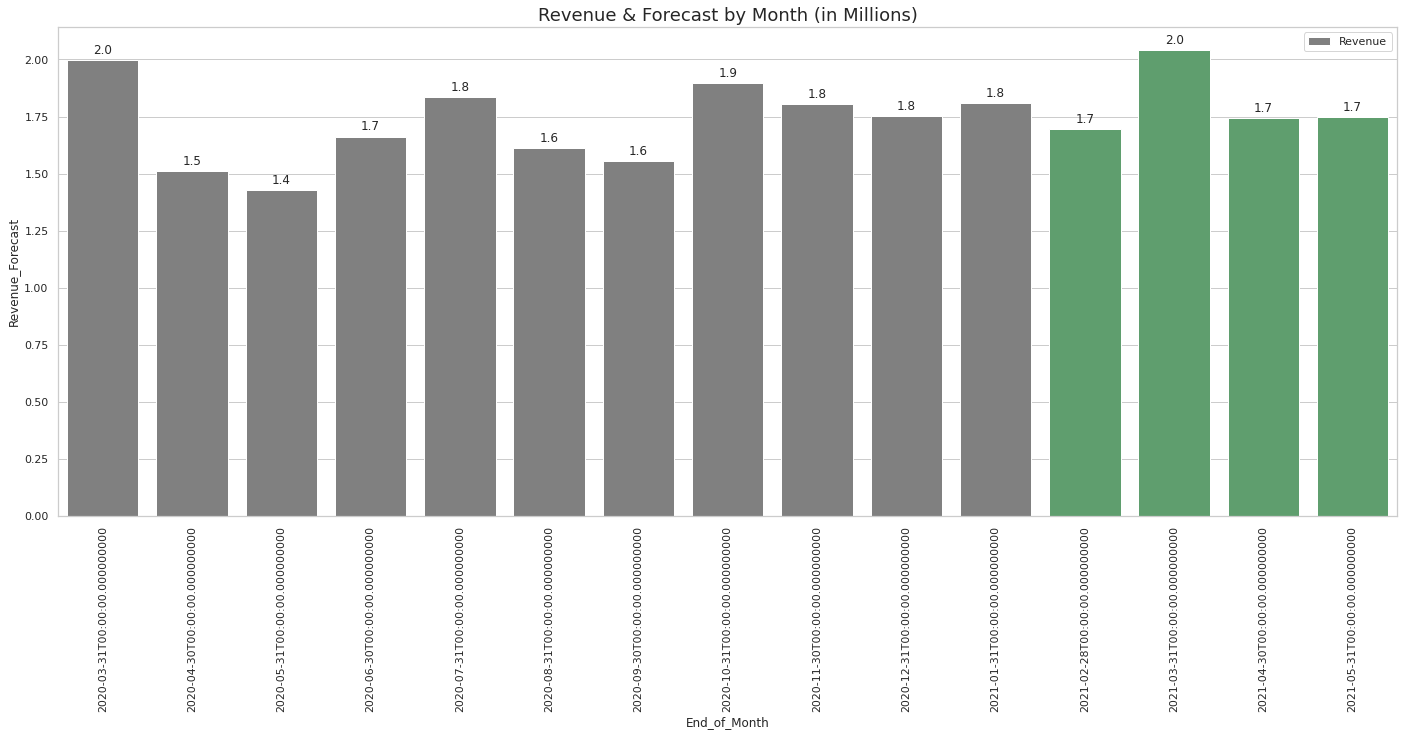

In [154]:
# Bar plot for history and forecast revenues summary by month

(fig, ax) = plt.subplots(figsize=(24, 9))
div_by_thousand = 1000
div_by_mil = 1000000
'''
final_merge_df1 = final_merge_df.pivot_table(index=['Snapshot_Date_Short','End_of_Month',
        'Relative_Month_Offset', 'Relative_Offset'],
        values='Revenue_Forecast', aggfunc=np.sum, margins=False)  # columns='Fin_Entity_ID',
final_merge_df1 = \
    final_merge_df1.reset_index(level=final_merge_df1.index.names)
'''
final_merge_df1 = final_merge_df.query('Relative_Snapshot_Month_Offset == 0').copy()
# final_merge_df1['Date'] = pd.to_datetime(final_merge_df1['End_of_Month'
#         ]).dt.date  # .astype(str)
final_merge_df1['Revenue_Forecast'] = \
    round(final_merge_df1['Revenue_Forecast'] / div_by_mil, 4)
values = final_merge_df1['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.barplot(  # alpha=0.50,
    x='End_of_Month',
    y='Revenue_Forecast',
    ci=None,
    data=final_merge_df1,
    palette=clrs,
    ax=ax,
    )
plt.xticks(rotation=90)
plt.title('Revenue & Forecast by Month (in Millions)', fontsize=18)
for p in g.patches:
    g.annotate(
        '{:,.1f}'.format(p.get_height()),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 10),
        textcoords='offset points',
        )
g.legend(['Revenue', 'Forecast'], facecolor='w')
plt.show()

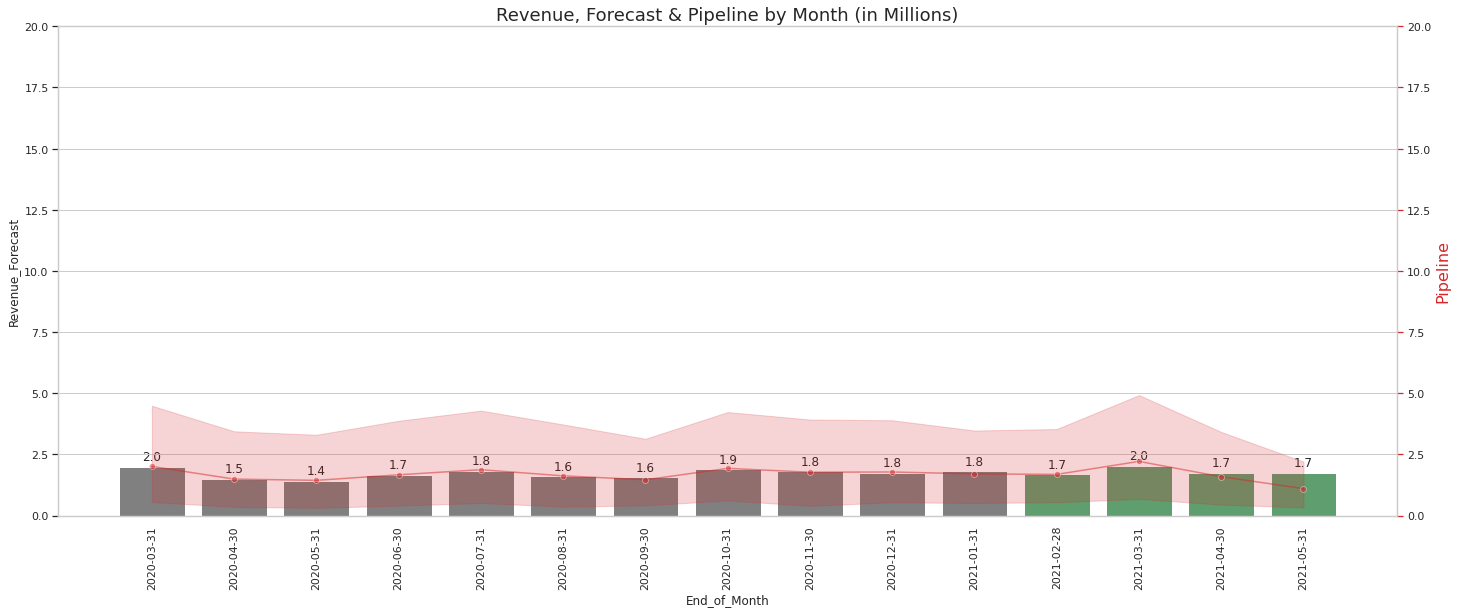

In [155]:
# Bar plot for history and forecast revenues summary by month with Revenue and pipeline line chart

(fig, ax1) = plt.subplots(figsize=(24, 9))
div_by_thousand = 1000
div_by_mil = 1000000
'''
final_merge_df1 = final_merge_df.pivot_table(index=['Snapshot_Date_Short','End_of_Month',
        'Relative_Month_Offset', 'Relative_Offset'],
        values='Revenue_Forecast', aggfunc=np.sum, margins=False)  # columns='Fin_Entity_ID',
final_merge_df1 = \
    final_merge_df1.reset_index(level=final_merge_df1.index.names)
'''
final_merge_df1 = final_merge_df.query('Relative_Snapshot_Month_Offset == 0').copy()
final_merge_df1['End_of_Month'] = pd.to_datetime(final_merge_df1['End_of_Month'
         ]).dt.date.astype(str)
final_merge_df1['Revenue_Forecast'] = \
    round(final_merge_df1['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df1['Pipeline'] = \
    round(final_merge_df1['Pipeline'] / div_by_mil, 4)
final_merge_df1['Revenue'] = \
    round(final_merge_df1['Revenue'] / div_by_mil, 4)
final_merge_df1['predicted'] = \
    round(final_merge_df1['predicted'] / div_by_mil, 4)
values = final_merge_df1['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.barplot(  # alpha=0.50,
    x='End_of_Month',
    y='Revenue_Forecast',
    ci=None,
    data=final_merge_df1,
    palette=clrs,
    ax=ax1,
    )
plt.xticks(rotation=90)
plt.ylim(0,20)
plt.title('Revenue, Forecast & Pipeline by Month (in Millions)', fontsize=18)
for p in g.patches:
    g.annotate(
        '{:,.1f}'.format(p.get_height()),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 10),
        textcoords='offset points',
        )
#g.legend(['Revenue'], facecolor='w')    
ax2 = ax1.twinx()
color='tab:red'
ax2.set_ylabel('Pipeline', fontsize=16, color=color)
g = sns.lineplot(
    x='End_of_Month',
    y='Pipeline',
    data=final_merge_df1,
    marker='o',
    sort=False,
    alpha=0.5, 
    ax=ax2,
    color=color
)
#g.legend(['Pipeline'], facecolor='w') 
ax2.tick_params(axis='y', color=color)
plt.ylim(0,20)
plt.show()

In [ ]:
# Bar plot for history and forecast revenues summary by month with Revenue and pipeline line chart

(fig, ax1) = plt.subplots(figsize=(24, 9))
div_by_thousand = 1000
div_by_mil = 1000000
'''
final_merge_df1 = final_merge_df.pivot_table(index=['Snapshot_Date_Short','End_of_Month',
        'Relative_Month_Offset', 'Relative_Offset'],
        values='Revenue_Forecast', aggfunc=np.sum, margins=False)  # columns='Fin_Entity_ID',
final_merge_df1 = \
    final_merge_df1.reset_index(level=final_merge_df1.index.names)
'''
final_merge_df1 = final_merge_df.query('Relative_Snapshot_Month_Offset >= -3 and Relative_Offset < 0').copy()
final_merge_df1['End_of_Month'] = pd.to_datetime(final_merge_df1['End_of_Month'
         ]).dt.date.astype(str)
final_merge_df1['Revenue_Forecast'] = \
    round(final_merge_df1['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df1['Pipeline'] = \
    round(final_merge_df1['Pipeline'] / div_by_mil, 4)
final_merge_df1['Revenue'] = \
    round(final_merge_df1['Revenue'] / div_by_mil, 4)
final_merge_df1['predicted'] = \
    round(final_merge_df1['predicted'] / div_by_mil, 4)
values = final_merge_df1['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.barplot(  # alpha=0.50,
    x='End_of_Month',
    y='Diff%',
    ci=None,
    data=final_merge_df1,
    color='tab:blue',
    ax=ax1,
    )
plt.xticks(rotation=90)
#plt.ylim(0,)
plt.title('Revenue - predicted Diff% & Diff by Month (in Millions)', fontsize=18)
for p in g.patches:
    g.annotate(
        '{:,.2f}'.format(p.get_height()),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 10),
        textcoords='offset points',
        )
#g.legend(['Revenue'], facecolor='w')    
ax2 = ax1.twinx()
color='tab:red'
ax2.set_ylabel('Diff', fontsize=16, color=color)
g = sns.lineplot(
    x='End_of_Month',
    y='Diff',
    data=final_merge_df1,
    marker='o',
    sort=False,
    alpha=0.5, 
    ax=ax2,
    color=color
)
#g.legend(['Pipeline'], facecolor='w') 
ax2.tick_params(axis='y', color=color)
#plt.ylim(0,5)
plt.show()

In [ ]:
# Bar plot for history and forecast revenues summary by month with Revenue and pipeline line chart

#(fig = plt.subplots(figsize=(24, 9))
div_by_thousand = 1000
div_by_mil = 1000000
'''
final_merge_df1 = final_merge_df.pivot_table(index=['Snapshot_Date_Short','End_of_Month',
        'Relative_Month_Offset', 'Relative_Offset'],
        values='Revenue_Forecast', aggfunc=np.sum, margins=False)  # columns='Fin_Entity_ID',
final_merge_df1 = \
    final_merge_df1.reset_index(level=final_merge_df1.index.names)
'''
final_merge_df1 = final_merge_df.query('Relative_Snapshot_Month_Offset >= -3 and Relative_Offset<0').copy()
final_merge_df1['End_of_Month'] = pd.to_datetime(final_merge_df1['End_of_Month'
         ]).dt.date.astype(str)
final_merge_df1['Revenue_Forecast'] = \
    round(final_merge_df1['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df1['Pipeline'] = \
    round(final_merge_df1['Pipeline'] / div_by_mil, 4)
final_merge_df1['Revenue'] = \
    round(final_merge_df1['Revenue'] / div_by_mil, 4)
final_merge_df1['predicted'] = \
    round(final_merge_df1['predicted'] / div_by_mil, 4)
values = final_merge_df1['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.jointplot(  
    data=final_merge_df1,
    x='Revenue',
    y='predicted',
    #hue='Snapshot_Date_Short',
    kind='reg',
    height=10
    )
#plt.xticks(rotation=90)
#plt.ylim(0,)
plt.suptitle('Predicted vs Actual Revenue (in Millions)', size=18)
plt.subplots_adjust( top = 0.95 ) 
'''
#g.legend(['Revenue'], facecolor='w')    
ax2 = ax1.twinx()
color='tab:red'
ax2.set_ylabel('Diff', fontsize=16, color=color)
g = sns.lineplot(
    x='End_of_Month',
    y='Diff',
    data=final_merge_df1,
    marker='o',
    sort=False,
    alpha=0.5, 
    ax=ax2,
    color=color
)
#g.legend(['Pipeline'], facecolor='w') 
ax2.tick_params(axis='y', color=color)
#plt.ylim(0,5)
'''
plt.show()

In [ ]:
# Bar plot for history and forecast revenues summary by month with Revenue and pipeline line chart

(fig, ax1) = plt.subplots(figsize=(24, 9))
div_by_thousand = 1000
div_by_mil = 1000000
'''
final_merge_df1 = final_merge_df.pivot_table(index=['Snapshot_Date_Short','End_of_Month',
        'Relative_Month_Offset', 'Relative_Offset'],
        values='Revenue_Forecast', aggfunc=np.sum, margins=False)  # columns='Fin_Entity_ID',
final_merge_df1 = \
    final_merge_df1.reset_index(level=final_merge_df1.index.names)
'''
final_merge_df1 = final_merge_df.query('Relative_Snapshot_Month_Offset >= -3').copy()
final_merge_df1['End_of_Month'] = pd.to_datetime(final_merge_df1['End_of_Month'
         ]).dt.date.astype(str)
final_merge_df1['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df1['Snapshot_Date_Short'
         ]).dt.date.astype(str)
final_merge_df1['Revenue_Forecast'] = \
    round(final_merge_df1['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df1['Pipeline'] = \
    round(final_merge_df1['Pipeline'] / div_by_mil, 4)
final_merge_df1['Revenue'] = \
    round(final_merge_df1['Revenue'] / div_by_mil, 4)
final_merge_df1['predicted'] = \
    round(final_merge_df1['predicted'] / div_by_mil, 4)
values = final_merge_df1['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.relplot(  
    data=final_merge_df1,
    x='End_of_Month',
    y='predicted',
    hue='Snapshot_Date_Short',
    kind='line',
    marker='o',
    height=10,
    aspect=2,
    ax=ax1
    )
plt.xticks(rotation=90)
#plt.ylim(0,)
plt.title('Predicted Revenue (in Millions)', fontsize=18)
# '''
#g.legend(['Revenue'], facecolor='w')    
ax2 = ax1.twinx()
color='tab:red'
ax2.set_ylabel('Revenue', fontsize=16, color=color)
g = sns.lineplot(
    data=final_merge_df1,
    x='End_of_Month',
    y='Pipeline',
    hue='Snapshot_Date_Short',
    marker='o',
    sort=False,
    alpha=0.5, 
    ax=ax2,
    color=color
)
#g.legend(['Pipeline'], facecolor='w') 
ax2.tick_params(axis='y', color=color)
#plt.ylim(0,5)
# '''
plt.show()

In [ ]:
# Bar plot for history and forecast revenues summary by month with Revenue and pipeline line chart

#(fig, ax) = plt.subplots(figsize=(24, 9))
div_by_thousand = 1000
div_by_mil = 1000000
'''
final_merge_df1 = final_merge_df.pivot_table(index=['Snapshot_Date_Short','End_of_Month',
        'Relative_Month_Offset', 'Relative_Offset'],
        values='Revenue_Forecast', aggfunc=np.sum, margins=False)  # columns='Fin_Entity_ID',
final_merge_df1 = \
    final_merge_df1.reset_index(level=final_merge_df1.index.names)
'''
final_merge_df1 = final_merge_df.query('Relative_Snapshot_Month_Offset >= -3 and Relative_Offset >= -3').copy()
final_merge_df1['End_of_Month'] = pd.to_datetime(final_merge_df1['End_of_Month'
         ]).dt.date.astype(str)
final_merge_df1['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df1['Snapshot_Date_Short'
         ]).dt.date.astype(str)
final_merge_df1['Revenue_Forecast'] = \
    round(final_merge_df1['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df1['Pipeline'] = \
    round(final_merge_df1['Pipeline'] / div_by_mil, 4)
final_merge_df1['Revenue'] = \
    round(final_merge_df1['Revenue'] / div_by_mil, 4)
final_merge_df1['predicted'] = \
    round(final_merge_df1['predicted'] / div_by_mil, 4)
values = final_merge_df1['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.catplot(  
    data=final_merge_df1,
    x='Snapshot_Date_Short',
    y='predicted',
    hue='End_of_Month',
    kind='bar',
    palette='PuBuGn',
    #alpha=.6,
    height=6,
    aspect=4,
    ax=ax
    )
#plt.xticks(rotation=90)
#plt.ylim(0,)
plt.title('Predicted Revenue (in Millions)', fontsize=18)
for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate(
            '{:,.1f}'.format(p.get_height()),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points',
            )
'''
#g.legend(['Revenue'], facecolor='w')    
ax2 = ax.twinx()
color='tab:red'
ax2.set_ylabel('Diff', fontsize=16, color=color)
g = sns.lineplot(
    x='Snapshot_Date_Short',
    y='Revenue',
    hue='End_of_Month',
    data=final_merge_df1,
    marker='o',
    sort=False,
    alpha=0.5, 
    ax=ax2,
    color=color
)
#g.legend(['Pipeline'], facecolor='w') 
ax2.tick_params(axis='y', color=color)
#plt.ylim(0,5)
'''
plt.show()

In [ ]:
# Bar plot for history and forecast revenues summary by month with Revenue and pipeline line chart

#(fig, ax) = plt.subplots(figsize=(24, 9))
div_by_thousand = 1000
div_by_mil = 1000000
'''
final_merge_df1 = final_merge_df.pivot_table(index=['Snapshot_Date_Short','End_of_Month',
        'Relative_Month_Offset', 'Relative_Offset'],
        values='Revenue_Forecast', aggfunc=np.sum, margins=False)  # columns='Fin_Entity_ID',
final_merge_df1 = \
    final_merge_df1.reset_index(level=final_merge_df1.index.names)
'''
final_merge_df1 = final_merge_df.query('Relative_Snapshot_Month_Offset >= -3 and Relative_Offset >= -3').copy()
final_merge_df1['End_of_Month'] = pd.to_datetime(final_merge_df1['End_of_Month'
         ]).dt.date.astype(str)
final_merge_df1['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df1['Snapshot_Date_Short'
         ]).dt.date.astype(str)
final_merge_df1['Revenue_Forecast'] = \
    round(final_merge_df1['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df1['Pipeline'] = \
    round(final_merge_df1['Pipeline'] / div_by_mil, 4)
final_merge_df1['Revenue'] = \
    round(final_merge_df1['Revenue'] / div_by_mil, 4)
final_merge_df1['predicted'] = \
    round(final_merge_df1['predicted'] / div_by_mil, 4)
values = final_merge_df1['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.catplot(  
    data=final_merge_df1,
    x='End_of_Month',
    y='predicted',
    hue='Snapshot_Date_Short',
    kind='bar',
    palette='PuBuGn',
    #alpha=.6,
    height=6,
    aspect=4,
    ax=ax
    )
#plt.xticks(rotation=90)
#plt.ylim(0,)
plt.title('Predicted Revenue (in Millions)', fontsize=18)
for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate(
            '{:,.1f}'.format(p.get_height()),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points',
            )
'''
#g.legend(['Revenue'], facecolor='w')    
ax2 = ax.twinx()
color='tab:red'
ax2.set_ylabel('Diff', fontsize=16, color=color)
g = sns.lineplot(
    x='Snapshot_Date_Short',
    y='Revenue',
    hue='End_of_Month',
    data=final_merge_df1,
    marker='o',
    sort=False,
    alpha=0.5, 
    ax=ax2,
    color=color
)
#g.legend(['Pipeline'], facecolor='w') 
ax2.tick_params(axis='y', color=color)
#plt.ylim(0,5)
'''
plt.show()

In [ ]:
# Bar plot for history and forecast revenues summary by month with Revenue and pipeline line chart

#(fig, ax) = plt.subplots(figsize=(24, 9))
div_by_thousand = 1000
div_by_mil = 1000000
'''
final_merge_df1 = final_merge_df.pivot_table(index=['Snapshot_Date_Short','End_of_Month',
        'Relative_Month_Offset', 'Relative_Offset'],
        values='Revenue_Forecast', aggfunc=np.sum, margins=False)  # columns='Fin_Entity_ID',
final_merge_df1 = \
    final_merge_df1.reset_index(level=final_merge_df1.index.names)
'''
final_merge_df1 = final_merge_df.query('Relative_Snapshot_Month_Offset >= -3').copy()
final_merge_df1['End_of_Month'] = pd.to_datetime(final_merge_df1['End_of_Month'
         ]).dt.date.astype(str)
final_merge_df1['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df1['Snapshot_Date_Short'
         ]).dt.date.astype(str)
final_merge_df1['Revenue_Forecast'] = \
    round(final_merge_df1['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df1['Pipeline'] = \
    round(final_merge_df1['Pipeline'] / div_by_mil, 4)
final_merge_df1['Revenue'] = \
    round(final_merge_df1['Revenue'] / div_by_mil, 4)
final_merge_df1['predicted'] = \
    round(final_merge_df1['predicted'] / div_by_mil, 4)
values = final_merge_df1['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.catplot(  
    data=final_merge_df1,
    x='End_of_Month',
    y='predicted',
    col='Snapshot_Date_Short',
    col_wrap=2,
    col_order=['2021-01-31','2020-12-31','2020-11-30','2020-10-31'],
    kind='bar',
    palette='PuBuGn',
    #alpha=.6,
    height=8,
    aspect=2,
    ax=ax
    )
#plt.ylim(0,)

for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate(
            '{:,.1f}'.format(p.get_height()),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points',
            )
g.set_xticklabels(rotation=90)
g.fig.suptitle('Predicted Revenue (in Millions) ', fontsize = 'x-large' ,  
               fontweight = 'bold' )
g.fig.subplots_adjust( top = 0.90 ) 
'''
#g.legend(['Revenue'], facecolor='w')    
ax2 = ax.twinx()
color='tab:red'
ax2.set_ylabel('Diff', fontsize=16, color=color)
g = sns.lineplot(
    x='Snapshot_Date_Short',
    y='Revenue',
    hue='End_of_Month',
    data=final_merge_df1,
    marker='o',
    sort=False,
    alpha=0.5, 
    ax=ax2,
    color=color
)
#g.legend(['Pipeline'], facecolor='w') 
ax2.tick_params(axis='y', color=color)
#plt.ylim(0,5)
'''
plt.show()

In [ ]:
# Bar plot for history and forecast revenues summary by month with Revenue and pipeline line chart

#(fig, ax) = plt.subplots(figsize=(24, 9))
div_by_thousand = 1000
div_by_mil = 1000000
'''
final_merge_df1 = final_merge_df.pivot_table(index=['Snapshot_Date_Short','End_of_Month',
        'Relative_Month_Offset', 'Relative_Offset'],
        values='Revenue_Forecast', aggfunc=np.sum, margins=False)  # columns='Fin_Entity_ID',
final_merge_df1 = \
    final_merge_df1.reset_index(level=final_merge_df1.index.names)
'''
final_merge_df1 = final_merge_df.query('Relative_Snapshot_Month_Offset >= -3').copy()
final_merge_df1['End_of_Month'] = pd.to_datetime(final_merge_df1['End_of_Month'
         ]).dt.date.astype(str)
final_merge_df1['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df1['Snapshot_Date_Short'
         ]).dt.date.astype(str)
final_merge_df1['Revenue_Forecast'] = \
    round(final_merge_df1['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df1['Pipeline'] = \
    round(final_merge_df1['Pipeline'] / div_by_mil, 4)
final_merge_df1['Revenue'] = \
    round(final_merge_df1['Revenue'] / div_by_mil, 4)
final_merge_df1['predicted'] = \
    round(final_merge_df1['predicted'] / div_by_mil, 4)
values = final_merge_df1['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.catplot(  
    data=final_merge_df1,
    x='End_of_Month',
    y='Revenue',
    col='Snapshot_Date_Short',
    col_wrap=2,
    col_order=['2021-01-31','2020-12-31','2020-11-30','2020-10-31'],
    kind='bar',
    palette='Greys',
    #alpha=.6,
    height=8,
    aspect=2,
    ax=ax
    )
#plt.ylim(0,)

for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate(
            '{:,.1f}'.format(p.get_height()),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points',
            )
g.set_xticklabels(rotation=90)
g.fig.suptitle('Revenue (in Millions) ', fontsize = 'x-large' ,  
               fontweight = 'bold' )
g.fig.subplots_adjust( top = 0.90 ) 
'''
#g.legend(['Revenue'], facecolor='w')    
ax2 = ax.twinx()
color='tab:red'
ax2.set_ylabel('Diff', fontsize=16, color=color)
g = sns.lineplot(
    x='Snapshot_Date_Short',
    y='Revenue',
    hue='End_of_Month',
    data=final_merge_df1,
    marker='o',
    sort=False,
    alpha=0.5, 
    ax=ax2,
    color=color
)
#g.legend(['Pipeline'], facecolor='w') 
ax2.tick_params(axis='y', color=color)
#plt.ylim(0,5)
'''
plt.show()

In [ ]:
# Bar plot for history and forecast revenues summary by month with Revenue and pipeline line chart

#(fig, ax) = plt.subplots(figsize=(24, 9))
div_by_thousand = 1000
div_by_mil = 1000000
'''
final_merge_df1 = final_merge_df.pivot_table(index=['Snapshot_Date_Short','End_of_Month',
        'Relative_Month_Offset', 'Relative_Offset'],
        values='Revenue_Forecast', aggfunc=np.sum, margins=False)  # columns='Fin_Entity_ID',
final_merge_df1 = \
    final_merge_df1.reset_index(level=final_merge_df1.index.names)
'''
final_merge_df1 = final_merge_df.query('Relative_Snapshot_Month_Offset >= -3 and Relative_Offset < 0').copy()
final_merge_df1['End_of_Month'] = pd.to_datetime(final_merge_df1['End_of_Month'
         ]).dt.date.astype(str)
final_merge_df1['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df1['Snapshot_Date_Short'
         ]).dt.date.astype(str)
final_merge_df1['Revenue_Forecast'] = \
    round(final_merge_df1['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df1['Pipeline'] = \
    round(final_merge_df1['Pipeline'] / div_by_mil, 4)
final_merge_df1['Revenue'] = \
    round(final_merge_df1['Revenue'] / div_by_mil, 4)
final_merge_df1['predicted'] = \
    round(final_merge_df1['predicted'] / div_by_mil, 4)
values = final_merge_df1['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.catplot(  
    data=final_merge_df1,
    x='End_of_Month',
    y='Diff%',
    col='Snapshot_Date_Short',
    col_wrap=2,
    col_order=['2021-01-31','2020-12-31','2020-11-30','2020-10-31'],
    kind='bar',
    palette='Blues',
    #alpha=.6,
    height=8,
    aspect=2,
    ax=ax
    )
#plt.ylim(0,)

for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate(
            '{:,.1f}'.format(p.get_height()),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points',
            )
g.set_xticklabels(rotation=90)
g.fig.suptitle('Revenue - predicted Diff% (for previous months)', fontsize = 'x-large' ,  
               fontweight = 'bold' )
g.fig.subplots_adjust( top = 0.90 ) 
'''
#g.legend(['Revenue'], facecolor='w')    
ax2 = ax.twinx()
color='tab:red'
ax2.set_ylabel('Diff', fontsize=16, color=color)
g = sns.lineplot(
    x='Snapshot_Date_Short',
    y='Revenue',
    hue='End_of_Month',
    data=final_merge_df1,
    marker='o',
    sort=False,
    alpha=0.5, 
    ax=ax2,
    color=color
)
#g.legend(['Pipeline'], facecolor='w') 
ax2.tick_params(axis='y', color=color)
#plt.ylim(0,5)
'''
plt.show()

In [ ]:
# Bar plot for history and forecast revenues summary by month with Revenue and pipeline line chart

#(fig, ax) = plt.subplots(figsize=(24, 9))
div_by_thousand = 1000
div_by_mil = 1000000
'''
final_merge_df1 = final_merge_df.pivot_table(index=['Snapshot_Date_Short','End_of_Month',
        'Relative_Month_Offset', 'Relative_Offset'],
        values='Revenue_Forecast', aggfunc=np.sum, margins=False)  # columns='Fin_Entity_ID',
final_merge_df1 = \
    final_merge_df1.reset_index(level=final_merge_df1.index.names)
'''
final_merge_df1 = final_merge_df.query('Relative_Snapshot_Month_Offset >= -3 and Relative_Offset >= -3').copy()
final_merge_df1['End_of_Month'] = pd.to_datetime(final_merge_df1['End_of_Month'
         ]).dt.date.astype(str)
final_merge_df1['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df1['Snapshot_Date_Short'
         ]).dt.date.astype(str)
final_merge_df1['Revenue_Forecast'] = \
    round(final_merge_df1['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df1['Pipeline'] = \
    round(final_merge_df1['Pipeline'] / div_by_mil, 4)
final_merge_df1['Revenue'] = \
    round(final_merge_df1['Revenue'] / div_by_mil, 4)
final_merge_df1['predicted'] = \
    round(final_merge_df1['predicted'] / div_by_mil, 4)
values = final_merge_df1['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.catplot(  
    data=final_merge_df1,
    x='End_of_Month',
    y='Pipeline',
    hue='Snapshot_Date_Short',
    kind='bar',
    palette='Greens',
    #alpha=.6,
    height=6,
    aspect=4,
    ax=ax
    )
#plt.xticks(rotation=90)
#plt.ylim(0,)
plt.title('Pipeline (in Millions)', fontsize=18)
for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate(
            '{:,.1f}'.format(p.get_height()),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points',
            )
'''
#g.legend(['Revenue'], facecolor='w')    
ax2 = ax.twinx()
color='tab:red'
ax2.set_ylabel('Diff', fontsize=16, color=color)
g = sns.lineplot(
    x='Snapshot_Date_Short',
    y='Revenue',
    hue='End_of_Month',
    data=final_merge_df1,
    marker='o',
    sort=False,
    alpha=0.5, 
    ax=ax2,
    color=color
)
#g.legend(['Pipeline'], facecolor='w') 
ax2.tick_params(axis='y', color=color)
#plt.ylim(0,5)
'''
plt.show()

In [ ]:
# Bar plot for history and forecast revenues summary by month with Revenue and pipeline line chart

#(fig, ax) = plt.subplots(figsize=(24, 9))
div_by_thousand = 1000
div_by_mil = 1000000
'''
final_merge_df1 = final_merge_df.pivot_table(index=['Snapshot_Date_Short','End_of_Month',
        'Relative_Month_Offset', 'Relative_Offset'],
        values='Revenue_Forecast', aggfunc=np.sum, margins=False)  # columns='Fin_Entity_ID',
final_merge_df1 = \
    final_merge_df1.reset_index(level=final_merge_df1.index.names)
'''
final_merge_df1 = final_merge_df.query('Relative_Snapshot_Month_Offset >= -3 and Relative_Offset >= -3').copy()
final_merge_df1['End_of_Month'] = pd.to_datetime(final_merge_df1['End_of_Month'
         ]).dt.date.astype(str)
final_merge_df1['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df1['Snapshot_Date_Short'
         ]).dt.date.astype(str)
final_merge_df1['Revenue_Forecast'] = \
    round(final_merge_df1['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df1['Pipeline'] = \
    round(final_merge_df1['Pipeline'] / div_by_mil, 4)
final_merge_df1['Revenue'] = \
    round(final_merge_df1['Revenue'] / div_by_mil, 4)
final_merge_df1['predicted'] = \
    round(final_merge_df1['predicted'] / div_by_mil, 4)
values = final_merge_df1['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.catplot(  
    data=final_merge_df1,
    x='Snapshot_Date_Short',
    y='Pipeline',
    hue='End_of_Month',
    kind='bar',
    palette='Greens',
    #alpha=.6,
    height=6,
    aspect=4,
    ax=ax
    )
#plt.xticks(rotation=90)
#plt.ylim(0,)
plt.title('Pipeline (in Millions)', fontsize=18)
for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate(
            '{:,.1f}'.format(p.get_height()),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points',
            )
'''
#g.legend(['Revenue'], facecolor='w')    
ax2 = ax.twinx()
color='tab:red'
ax2.set_ylabel('Diff', fontsize=16, color=color)
g = sns.lineplot(
    x='Snapshot_Date_Short',
    y='Revenue',
    hue='End_of_Month',
    data=final_merge_df1,
    marker='o',
    sort=False,
    alpha=0.5, 
    ax=ax2,
    color=color
)
#g.legend(['Pipeline'], facecolor='w') 
ax2.tick_params(axis='y', color=color)
#plt.ylim(0,5)
'''
plt.show()

In [ ]:
sns.set()
div_by_thousand = 1000
div_by_mil = 1000000
final_merge_df1 = final_merge_df.query('Relative_Snapshot_Month_Offset >= -1').copy()
final_merge_df1['Revenue_Forecast'] = \
    round(final_merge_df1['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df1['Pipeline'] = \
    round(final_merge_df1['Pipeline'] / div_by_mil, 4)
values = final_merge_df1['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]
g = sns.FacetGrid(data=final_merge_df1, col='Snapshot_Date_Short',
                  height=8, aspect=2.5, col_wrap=2,
                  palette=clrs) #alpha=0.50

g.map_dataframe(sns.barplot, x='End_of_Month', y='Revenue_Forecast',
                palette=clrs)
for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate(
            '{:,.2f}'.format(p.get_height()),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points',
            )
g.set_xticklabels(rotation=90)
g.fig.suptitle('Revenue & Forecast by Month', fontsize = 'x-large' ,  
               fontweight = 'bold' )
g.fig.subplots_adjust( top = 0.90 ) 
g.fig.legend(['Revenue', 'Forecast'], facecolor='w')
plt.show()


In [ ]:
final_merge_df.plot(x='End_of_Month', y='Revenue_Forecast')

In [ ]:
final_merge_pivot1.plot()

In [ ]:
# Bar plot for history and forecast revenues summary by month
sns.set()
#(fig, ax) = plt.subplots(figsize=(24, 9))

div_by_thousand = 1000
div_by_mil = 1000000
final_merge_df2= final_merge_df.query('Relative_Snapshot_Month_Offset >= -3').copy()
final_merge_df2['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df2['Snapshot_Date_Short']).dt.date.astype(str)
final_merge_df2['Revenue_Forecast'] = \
    round(final_merge_df2['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df2['Pipeline'] = \
    round(final_merge_df2['Pipeline'] / div_by_mil, 4)
final_merge_df2['predicted'] = \
    round(final_merge_df2['predicted'] / div_by_mil, 4)
values = final_merge_df2['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.catplot(  # alpha=0.50,
    x='End_of_Month',
    y='predicted',
    data=final_merge_df2,
    hue='Relative_Offset',
    col='Snapshot_Date_Short',
    col_wrap=2,
    kind='bar',
    height=6,
    aspect=2,
    palette=clrs
    )

for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate(
            '{:,.1f}M'.format(p.get_height()),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points',
            )
g1 = sns.catplot(x='End_of_Month', y='Pipeline', 
    data=final_merge_df2,
    col='Snapshot_Date_Short',
    col_wrap=2,
    kind='bar',
    height=6,
    aspect=2,
    palette='Greens' )

g.set_xticklabels(rotation=90)
g.fig.suptitle('Predicted Forecast by Snapshot Date, Month', fontsize = 'x-large' ,  
               fontweight = 'bold' )
g.fig.subplots_adjust( top = 0.90 ) 
#g.fig.legend(['Revenue', 'Forecast'], facecolor='w')
plt.show()

In [ ]:
# Bar plot for history and forecast revenues summary by month
sns.set()
#(fig, ax) = plt.subplots(figsize=(24, 9))

div_by_thousand = 1000
div_by_mil = 1000000
final_merge_df2= final_merge_df.query('Relative_Snapshot_Month_Offset >= -3').copy()
final_merge_df2['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df2['Snapshot_Date_Short']).dt.date.astype(str)
final_merge_df2['Revenue_Forecast'] = \
    round(final_merge_df2['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df2['Pipeline'] = \
    round(final_merge_df2['Pipeline'] / div_by_mil, 4)
final_merge_df2['predicted'] = \
    round(final_merge_df2['predicted'] / div_by_mil, 4)
values = final_merge_df2['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.catplot(  # alpha=0.50,
    x='End_of_Month',
    y='predicted',
    data=final_merge_df2,
    #hue='Relative_Offset',
    col='Snapshot_Date_Short',
    col_wrap=2,
    kind='bar',
    height=6,
    aspect=2,
    palette=clrs
    )

for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate(
            '{:,.1f}M'.format(p.get_height()),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points',
            )
g1 = sns.catplot(x='End_of_Month', y='Pipeline', 
    data=final_merge_df2,
    col='Snapshot_Date_Short',
    col_wrap=2,
    kind='bar',
    height=6,
    aspect=2,
    palette='Greens' )

g.set_xticklabels(rotation=90)
g.fig.suptitle('Predicted Forecast by Snapshot Date, Month', fontsize = 'x-large' ,  
               fontweight = 'bold' )
g.fig.subplots_adjust( top = 0.90 ) 
#g.fig.legend(['Revenue', 'Forecast'], facecolor='w')
plt.show()

In [ ]:
# Bar plot for history and forecast revenues summary by month
sns.set()
#(fig, ax) = plt.subplots(figsize=(24, 9))

div_by_thousand = 1000
div_by_mil = 1000000
final_merge_df2= final_merge_df.query('Relative_Snapshot_Month_Offset >= -3').copy()
final_merge_df2['Snapshot_Date_Short'] = pd.to_datetime(final_merge_df2['Snapshot_Date_Short']).dt.date.astype(str)

final_merge_df2['Revenue_Forecast'] = \
    round(final_merge_df2['Revenue_Forecast'] / div_by_mil, 4)
final_merge_df2['Revenue'] = \
    round(final_merge_df2['Revenue'] / div_by_mil, 4)
final_merge_df2['Pipeline'] = \
    round(final_merge_df2['Pipeline'] / div_by_mil, 4)
final_merge_df2['predicted'] = \
    round(final_merge_df2['predicted'] / div_by_mil, 4)

values = final_merge_df2['Relative_Offset'].unique()
clrs = [('grey' if x < 0 else 'g') for x in values]

# revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)

g = sns.catplot(  alpha=0.50,
    x='End_of_Month',
    y='predicted',
    data=final_merge_df2,
    #hue='Relative_Offset',
    col='Snapshot_Date_Short',
    col_wrap=2,
    kind='bar',
    height=6,
    aspect=2,
    palette='BrBG'
    )
for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate(
            '{:,.1f}M'.format(p.get_height()),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points',
            )
g.map_dataframe(sns.barplot, x='End_of_Month', y='Revenue', color = '.5',
                palette='Greys')
g.map_dataframe(sns.barplot, x='End_of_Month', y='Pipeline', color = '.5',
                palette='Greens')
g.add_legend()
g.set_xticklabels(rotation=90)
g.fig.suptitle('Predicted Forecast by Snapshot Date, Month', fontsize = 'x-large' ,  
               fontweight = 'bold' )
g.fig.subplots_adjust( top = 0.90 ) 
#g.fig.legend()
plt.show()

In [ ]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
sns.set()
dfx = final_merge_pivot1.reset_index(inplace=False).copy()
g = sns.catplot(
    data=dfx,
    x='End_of_Month',
    y='predicted',
    hue='Snapshot_Date_Short',
    kind='bar',
    palette='BuGn',
    height=10,
    aspect=2
    )
g.set_xticklabels(rotation=90)
g.fig.suptitle('Predicted Forecast by Snapshot Date, Month',
               fontsize='large', fontweight='bold')
g.fig.subplots_adjust(top=0.90)
g


In [ ]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
sns.set()
dfx = final_merge_pivot1.reset_index(inplace=False).copy()
g = sns.catplot(
    data=dfx,
    x='Snapshot_Date_Short',
    y='predicted',
    hue='End_of_Month',
    kind='bar',
    palette='BuGn',
    height=10,
    aspect=2
    )
g.set_xticklabels(rotation=90)
g.fig.suptitle('Predicted Forecast by Snapshot Date, Month',
               fontsize='large', fontweight='bold')
g.fig.subplots_adjust(top=0.90)
g


In [ ]:
STOP*************************************************************

In [ ]:
Operationalize
#Operationalization means getting the model into the cloud so that other can run it after you close the notebook. We will create a docker running on Azure Container Instances with the model.
description = 'AutoML Revenue forecaster'
tags = None
model = remote_run.register_model(model_name = model_name, description = description, tags = tags)

print(remote_run.model_id)

In [ ]:
#Develop the scoring script
#For the deployment we need a function which will run the forecast on serialized data. It can be obtained from the best_run.
script_file_name = 'score_fcast.py'
best_run.download_file('outputs/scoring_file_v_1_0_0.py', script_file_name)

In [ ]:
#Deploy the model as a Web Service on Azure Container 
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice
from azureml.core.webservice import Webservice
from azureml.core.model import Model

inference_config = InferenceConfig(environment = best_run.get_environment(), 
                                   entry_script = script_file_name)

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 2, 
                                               tags = {'type': 'automl-forecasting'},
                                               description = 'Automl forecasting revenue service')

aci_service_name = 'automl-revenue-forecast-01'
print(aci_service_name)
aci_service = Model.deploy(ws, aci_service_name, [model], inference_config, aciconfig)
aci_service.wait_for_deployment(True)
print(aci_service.state)

In [ ]:
aci_service.get_logs()

In [ ]:
#Call the service
import json
X_query = X_test.copy()
# We have to convert datetime to string, because Timestamps cannot be serialized to JSON.
X_query[time_column_name] = X_query[time_column_name].astype(str)
# The Service object accept the complex dictionary, which is internally converted to JSON string.
# The section 'data' contains the data frame in the form of dictionary.
test_sample = json.dumps({'data': X_query.to_dict(orient='records')})
response = aci_service.run(input_data = test_sample)
# translate from networkese to datascientese
try: 
    res_dict = json.loads(response)
    y_fcst_all = pd.DataFrame(res_dict['index'])
    y_fcst_all[time_column_name] = pd.to_datetime(y_fcst_all[time_column_name], unit = 'ms')
    y_fcst_all['forecast'] = res_dict['forecast']    
except:
    print(res_dict)

In [ ]:
y_fcst_all.head()

In [ ]:
#Delete the web service if desired
#serv = Webservice(ws, 'automl-revenue-forecast-01')
#serv.delete()     # don't do it accidentally

In [ ]:
STOP

In [ ]:
#Export revenue only for time series forecast
#cols = revhist1.columns
#revtime_hist = merge_df[cols].query('End_of_Month < @current_eom').reset_index(drop=True)
#revtime_hist = merge_final.query('End_of_Month < @current_eom').reset_index(drop=True)
#revtime_hist.to_csv('revtime_hist.csv', index=False)
#revtime_foreast = merge_final.query('End_of_Month >= @current_eom').reset_index(drop=True)
#revtime_foreast.drop(columns=['Revenue'], axis=1, inplace = True)
#revtime_foreast.to_csv('revtime_foreast.csv', index=False)

In [ ]:
#Plot dataset
sns.set()
sns.set_context('talk') #In order of relative size they are: paper, notebook, talk, and poster. Notebook is default
sns.set(style='whitegrid') #Seaborn has five built-in themes to style its plots: darkgrid, whitegrid, dark, white, and ticks. 
# Save a palette to a variable:
palette = sns.color_palette('Accent',8)
# Use palplot and pass in the variable:
sns.palplot(palette)
# Set the palette using the name of a palette:
sns.set_palette(palette)

dataset = revtime_hist
dataset['End_of_Month'] = pd.to_datetime(dataset['End_of_Month'])
dataset = dataset.set_index('End_of_Month')
values = dataset.values
# specify columns to plot
groups = [0,1] #, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.1, loc='right')
    i += 1
plt.show()

In [ ]:
dataset['Revenue'].plot()